# Anomaly Detection using Autoencoder

Date: 07.06.2025<br>
Author: Hiroyuki Murakami (<Hiroyuki.Murakami@noaa.gov>), Sophia Zhou (sz3962@princeton.edu)

## Introduction

This project is for introducing the anomaly detection method using deep learning, so called "autoencoder", for daily precipitation. <br>

Before reading this jupyter notebook, following web sites should be read to understand the basic consept of anomaly detection and autoencoder.<br>
 - [Intro to anomaly detection with OpenCV, Computer Vision, and scikit-learn](https://pyimagesearch.com/2020/01/20/intro-to-anomaly-detection-with-opencv-computer-vision-and-scikit-learn/)
 - [Anomaly detection with Keras, TensorFlow, and Deep Learning](https://pyimagesearch.com/2020/03/02/anomaly-detection-with-keras-tensorflow-and-deep-learning/)
 - [Autoencoders with Keras, TensorFlow, and Deep Learning](https://pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/)

Please also read following paper for the details of methodology intoduced in this jupyter notebook.<br>
 - Murakami, H., T. L. Delworth, W. F. Cooke, S. B. Kapnick, and P. -C. Hsu, 2022: Increasing frequency of anomalous precipitation events in Japan detected by a deep learning autoencoder. Earth’s Future, 10, e2021EF002481. [Link](http://dx.doi.org/10.1029/2021EF002481)

The methodology and codes were based on the codes in [Autoencoders with Keras, TensorFlow, and Deep Learning](https://pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/).


## Required Installed Python Packages

Following Python packages are required for this Jupyter-Notebook. <br>
  > tensorflow, scikit-learn, pillow, h5py, keras, netCDF4, pandas, matplotlib, cartopy, numpy, pickle, jupyter, jupyter_contrib_nbextensions

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#import sys
#sys.path.append('/content/drive/MyDrive/Autoencoder')

In [ ]:
#!yes | pip uninstall shapely
#!pip install shapely --no-binary shapely

In [ ]:
#!pip install cartopy

In [ ]:
#!pip install netcdf4

In [ ]:
# import the necessary packages
import os
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LatitudeFormatter,LongitudeFormatter

import matplotlib.cm as cm
import pandas as pd
from netCDF4 import num2date, Dataset
import math
import pickle

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

from pyimagesearch.convautoencoder import ConvAutoencoder

from mylib.save_load_file import pickle_dump, pickle_load
from mylib.mystat import MYSTAT

#from cdo import Cdo

import warnings
warnings.filterwarnings('ignore')

In [ ]:
mystat = MYSTAT() # my own statistical package

If you don't see any errr messages, all of the Python packages have been normaly installed.

# Parameter Setting

In [ ]:
#--domain
domain="EU"
#domain="JP"

Domain of interest

In [ ]:
#--Season
if domain=="JP":
    model="APHRODITE" # http://aphrodite.st.hirosaki-u.ac.jp/
    tsyear=1977
    teyear=2015
    season="MJJASO" # May-Octber
elif domain=="USA":
    model="PRISMG" # https://prism.oregonstate.edu/
    tsyear=1981
    teyear=2021
    season="JAS" # July-September
elif domain=="EU":
  model = "E-OBS"  # https://cds.climate.copernicus.eu/cdsapp#!/dataset/insitu-gridded-observations-europe?tab=overview
  #tsyear = 1950
  tsyear = 1971
  #tsyear = 1981
  teyear = 2023
  season = "MJJASO"

In [ ]:
#--Test Model
testmodel="SPEAR-MED-ALLSSP585"
#testmodel="SPEAR-MED-NATURAL"
#testmodel="SPEAR-MED-COMB-ALLSSP585"

In [ ]:
if testmodel[0:9]=="SPEAR-MED":
    emax=30 # ensembe member for tested data
    emax2=emax # emax for test
    testmodel2=testmodel.split("-")[-1]
#    tsyear2=1971
    tsyear2=1971
    teyear2=2100


If USA is chosen, the [PRISM](https://prism.oregonstate.edu/) precipitation data is used and the analysis period is 1981-2021 for July-September.<br>
If JP is chosen, the [APHRODITE](http://aphrodite.st.hirosaki-u.ac.jp/) precipitation data is used and the analysis period is 1977-2015 for May-October.<br>
If EU is chosen, the [E-OBS](https://cds.climate.copernicus.eu/datasets/insitu-gridded-observations-europe?tab=overview) precipitation data is used and the analysis period is 1977-2023 for May-October.<br>

In [ ]:
#--Grid type
if domain=="JP":
    grid="HGRID" # 25-km grid
elif domain=="USA":
    grid="SGRID" # 50-km grid
elif domain=="EU":
   #grid="OGRID" # 50-km grid not sure if this is right
    grid="SGRID" # 50-km grid not sure if this is right

Precipitation GPV is on the SGRID (50-km grid) for USA<br>
Precipitation GPV is on the HGRID (25-km grid) for JP<br>
Precipitation GPV is on the SGRID (50-km grid) for EU

In [ ]:
#--Element
elem="PRECIP"

#--Climatology
runclim="RCLIM" #running mean climate

#--days of running mean
runday = 5

#--Units of input data
vunits = 'mm/day'

- The precipitation data used here are the 5-day running mean precipitation anomalies.
- The anomalies of daily mean precipitation were obtained by subtracting the moving 20-yr climatological daily mean (derived from the preceding 20-yr data) from the raw data. Then, 5-day running-mean anomalies were computed by averaging the anomalies using the previous 5 days to remove the short-term weather events (e.g., squall lines). Therefore, the target is large-scale anomalous precipitation that lasts for a few days rather than short-term daily extreme precipitation events.

In [ ]:
#--parameters for season
if season=="DJF":
    selmonths="1,2,12"
elif season=="JAS":
    selmonths="7,8,9"
elif season=="MJJASO":
    selmonths="5,6,7,8,9,10"
elif season=="AMJJAS":
    selmonths="4,5,6,7,8,9"
elif season=="JJAS":
    selmonths="6,7,8,9"
print ("selmonths=",selmonths)

"selmonths" is used for reading input data through the python-cdo later.

In [ ]:
#--parameters for plotting
if domain=="JP":
    ddomain = [123,146,24,46]
    figsize = (20,12)
    legend_posi = [0.2, 0.1, 0.6, 0.03]
    contours=np.arange(-15.0,15.0,0.5) # set contours to plot later
    cmap=cm.bwr_r # set colormap

elif domain=="USA":
    #ddomain = [232,295,22,51] # draw domain
    ddomain = [232,295,23,46] # draw domain

    figsize = (20,10)
    legend_posi = [0.2, 0.2, 0.6, 0.03]
    contours=np.arange(-10.0,10.0,0.5) # set contours to plot later
    cmap=cm.bwr_r # set colormap
elif domain=="EU":
    #ddomain = [232,295,22,51] # draw domain
   #ddomain = [-24.5,45,26,71] # what is domain? ******* NEEDS CHANGE -> This is the domain of plot: [west, east, south, north] given in longigudes and latitudes
    ddomain = [-11.5, 45.0,32.5,71.0]
    figsize = (20,15)
    legend_posi = [0.2, 0.2, 0.6, 0.01]
    contours=np.arange(-10.0,10.0,0.5) # set contours to plot later
    cmap=cm.bwr_r # set colormap

    dlon0,dlat0=5,5
    xticks0=np.arange(-20,45,dlon0)
    yticks0=np.arange(30,70,dlat0)

## Observed dataset

In [ ]:
if domain=="EU":
    #datadir = "/content/drive/MyDrive/Precip_Europe"
    #ifile = "%s/merge2_SPEAR_MED_EUROPE_anom_1950-2023_cprev20yrs.nc" % (datadir)
    datadir = "/archive/hnm/for_someone/Sophia/RR"
    if grid=="OGRID":
        ifile = "%s/merge_SPEAR_1x1_5-day_anom_1950-2023_cprev20yrs.nc" % (datadir)
        regfile = "/archive/hnm/Comm/grid_1x1_EUROPE3_europeregion.nc"
    elif grid=="SGRID":
        ifile = "%s/merge_SPEAR_spear_m3d_5-day_anom_1950-2023_cprev20yrs.nc" % (datadir)
        regfile = "/archive/hnm/Comm/grid_SPEAR_MED_EUROPE3_europeregion.nc"

#cdo.infov(input=ifile)

These parameters are used for drawing maps using Basemap.

In [ ]:
#--Output Data Directory
datatype="test7_spear_med_model_combinedautoencoder_1971-2100_copy2"

print ("Input Directory=",datadir)
print ("Output Directory=",datatype)

In [ ]:
domain = "EU"

Define input and output directories.

In [ ]:
odirs2 = ["output","anomaly","output_model","anomaly_model","output_test","anomaly_test","restored","restored_model","test","restored_test","output_119","output_nat","output_245","output_370","output_534"]

for odir2 in odirs2:
    if not os.path.exists("%s/%s" % (datatype,odir2)):
        os.makedirs("%s/%s" % (datatype,odir2))
    print  (datatype+"/"+odir2)
    print(datatype)


Creating output directory. Data structure is as follows.

<pre>
   |-- Input_data
   |     |--AphroJP_V1207_DPREC.1900-2010_V1207R3_DPREC.2011-2015_HiFLOR_5-day_anom_cprev20yrs.nc (APRODITE Data)
   |     |
   |     |--PRISM_ppt_stable_4kmM3_1981-2021_GSPEAR_5-day_anom_cprev20yrs.nc (PRISM Data)
   |
   |-- Output_JP (output for anmaly detection for the Japan domain)
   |     |--anomaly (output directory for picutres of anomalous events)
   |     |    |--cluster6 (output for K-mean Cluster)
   |     |
   |     |--output (output directory for MSE and autoencoder model)
   |
   |-- Output_USA (output for anmaly detection for the USA domain)
   |     |--anomaly (output directory for picutres of anomalous events)
   |     |    |--cluster6 (output for K-mean Cluster)
   |     |
   |     |--output (output directory for MSE and autoencoder model)
   |
   |-- mylib (includes statistical codes)
   |
   |-- pyimagesearch (includes tensorflow codes)
   |
   |-- pics (some reference pictures)
  
</pre>

In [ ]:
#parameters for normalizing
if elem=="PRECIP":
    if domain=="JP":
        maxvalue = 150
        minvalue = -40
    elif domain=="USA":
        maxvalue = 100
        minvalue = -40
    elif domain=="EU":
        maxvalue = 200
        minvalue = -50


# NEEDS CHANGE
print ("normalized = (rawdata - %i)/(%i - %i)" % (minvalue,maxvalue,minvalue))

This determins the parameter for normalization.<br>
Precipitation data (mm/day) is normalized resulting in normalized data that approximately range 0-1.<br>
> normalized = (rawdata - minvalue)/(maxvalue - minvalue)

# Subroutines

## Padding

In [ ]:
if domain=="JP":
    if grid=="HGRID":
        top=4
        bot=4
        left=2
        right=2

elif domain=="USA":
    if grid=="SGRID":
        top=2
        bot=1
        left=1
        right=1
elif domain=="EU": # NEEDS CHANGING
    if grid=="SGRID":
        top=1
        bot=0
        left=2
        right=2
    elif grid=="OGRID":
        top=1
        bot=0
        left=0
        right=0

pad_width1=((0,0),(bot,top),(left,right))
pad_width2=((0,0),(0,0),(bot,top),(left,right))

print ("pad=",pad_width1)

Because a specific number of grid sizes that is computationally efficient, zero values were further padded to the edges of each longitude and latitude axis after the normalization; namely, four grids on both sides of longitudinal edges and two grids on both sides of latitudinal edges were padded with zero values for HGRID.<br>

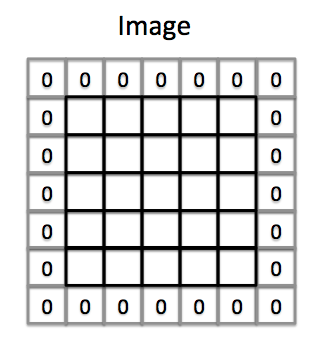

For USA (PRISM data), the original dimension (Time, Latitude, Longitude) = (3772, 29, 50) is expanded to (3772, 32, 52).<br>
For JP (APHRODITE data), the original dimension (Time, Latitude, Longitude) = (7176, 88, 92) is expanded to (7176, 96, 96).

In [ ]:
def pad_remover(rdata,domain,grid, multidata=False):
    ndim = rdata.ndim
    if domain=="JP":
        if grid=="HGRID":
            if ndim==4:
                if multidata:
                    recon = rdata[:,4:-4,2:-2,0]
                else:
                    recon = rdata[0,4:-4,2:-2,0]
            elif ndim==3:
                recon = rdata[4:-4,2:-2,0]
    elif domain=="USA":
        if grid=="SGRID":
            if ndim==4:
                if multidata:
                    recon = rdata[:,1:-2,1:-1,0]
                else:
                    recon = rdata[0,1:-2,1:-1,0]
            elif ndim==3:
                recon = rdata[1:-2,1:-1,0]
    elif domain=="EU":
        if ndim==4:
            if multidata:
                if top==0 and right!=0:
                    recon = rdata[:,bot::,left:-right,0]
                elif top!=0 and right==0:
                    recon = rdata[:,bot:-top,left::,0]
                elif top==0 and right==0:
                    recon = rdata[:,bot::,left::,0]
                else:
                    recon = rdata[:,bot:-top,left:-right,0]
            else:
                if top==0 and right!=0:
                    recon = rdata[0,bot::,left:-right,0]
                elif top!=0 and right==0:
                    recon = rdata[0,bot:-top,left::,0]
                elif top==0 and right==0:
                    recon = rdata[0,bot::,left::,0]
                else:
                    recon = rdata[0,bot:-top,left:-right,0]

        elif ndim==3:
            if top==0 and right!=0:
                recon = rdata[bot::,left:-right,0]
            elif top!=0 and right==0:
                recon = rdata[bot:-top,left::,0]
            elif top==0 and right==0:
                recon = rdata[bot::,left::,0]
            else:
                recon = rdata[bot:-top,left:-right,0]

    return recon

This function is used for removing padded data to restore the data on original grid

## Subroutine for Computing Linear Trend

In [ ]:
def linreg(X,Y):
    """
     return a,b in solution to y = ax + b such that root mean square distance
     between trend line and original points is minimized
    """
    N = len(X)
    Sx = Sy = Sxx = Syy = Sxy = 0.0

    for x, y in zip(X, Y):
        Sx = Sx + x
        Sy = Sy + y
        Sxx = Sxx + x*x
        Syy = Syy + y*y
        Sxy = Sxy + x*y
    det = Sxx * N - Sx * Sx
    aa = (Sxy * N - Sy * Sx)/det
    bb = (Sxx * Sy - Sx * Sxy)/det
    YY2 = aa * X + bb
    return X, YY2, aa


This function is used for computing linear trend.

## Subroutine for Mann-Kendall Trend Test

In [ ]:
def mk_test(x, alpha = 0.05):
    from scipy.stats import norm
    """
    this perform the MK (Mann-Kendall) test to check if the trend is present in
    data or not

    Input:
        x:   a vector of data
        alpha: significance level

    Output:
        h: True (if trend is present) or False (if trend is absence)
        p: p value of the sifnificance test

    Examples
    --------
      >>> x = np.random.rand(100)
      >>> h,p = mk_test(x,0.05)  # meteo.dat comma delimited
    """
    n = len(x)

    # calculate S
    s = 0
    for k in range(n-1):
        for j in range(k+1,n):
            s += np.sign(x[j] - x[k])

    # calculate the unique data
    unique_x = np.unique(x)
    g = len(unique_x)

    # calculate the var(s)
    if n == g: # there is no tie
        var_s = (n*(n-1)*(2*n+5))/18
    else: # there are some ties in data
        tp = np.zeros(unique_x.shape)
        for i in range(len(unique_x)):
            tp[i] = sum(unique_x[i] == x)
        var_s = (n*(n-1)*(2*n+5) + np.sum(tp*(tp-1)*(2*tp+5)))/18

    if s>0:
        z = (s - 1)/np.sqrt(var_s)
    elif s == 0:
        z = 0
    elif s<0:
        z = (s + 1)/np.sqrt(var_s)

    # calculate the p_value
    p = 2*(1-norm.cdf(abs(z))) # two tail test
    h = abs(z) > norm.ppf(1-alpha/2)

    return h, p

## Subroutine for Regional statistics

In [ ]:
def regional_stats(uids,regids,rdata,kind="mean"):

     values_ = np.zeros(len(uids))

     for jj,uid in enumerate(uids):
         igrid_ = np.where(regids==uid)
         if kind=="mean":
             values_[jj] = rdata[igrid_].mean()
         elif kind=="max":
             values_[jj] = rdata[igrid_].max()
         elif kind=="min":
             values_[jj] = rdata[igrid_].min()

     if kind=="mean":
         ireg = np.argmax(values_)
     elif kind=="max":
         ireg = np.argmax(values_)
     elif kind=="min":
         ireg = np.argmin(values_)

     return uids[ireg]

This function is used for computing statistical significance in trend ([Mann-Kendall test](https://vsp.pnnl.gov/help/vsample/design_trend_mann_kendall.htm)).

# Reading Input Data

## Reading regional mask data

In [ ]:
fXX = Dataset(regfile,"r")

jreg1 = fXX.variables['jreg1'][0]
jreg2 = fXX.variables['jreg2'][0]

jreg1_uids = np.unique(jreg1)
jreg2_uids = np.unique(jreg2)

#--- use jreg2
jreg = jreg2
jreg_uids = jreg2_uids
jreg_uids= [x for x in jreg2_uids if x != 0]


nreg = len(jreg_uids)
print (nreg)
sregnames={
    1:"Eastern Europe",
    2:"Northern Europe",
    3:"Central Europe",
    4:"Southeastern Europe",
    5:"Western Europe",
    6:"Southern Europe",
}

## Reading Observed Precipitation Dataset (PRISM or APHRODITE)

In [ ]:
if model=="APHRODITE":
    ifile1 = "%s/AphroJP_V1207_DPREC.1900-2010_V1207R3_DPREC.2011-2015_HiFLOR_5-day_anom_cprev20yrs.nc"  % (datadir)
    ielem = elem.lower()
elif model=="PRISMG":
    ifile1 = "%s/PRISM_ppt_stable_4kmM3_1981-2021_GSPEAR_5-day_anom_cprev20yrs.nc" % (datadir)
    ielem= "data"
elif model=="E-OBS":
    if grid=="SGRID":
        ifile1 = "%s/merge_RR_SPEAR_MED_EUROPE3_anom_1950-2023_cprev20yrs.nc" % (datadir)
    elif grid=="OGRID":
        ifile1 = "%s/merge_RR_1x1_EUROPE3_5-day_anom_1950-2023_cprev20yrs.nc" % (datadir)

    ielem= "rr" # made successful change here

print ("input file=",ifile1)
f11 = Dataset(ifile1,"r")

times_orig = f11.variables['time']
dates_orig = num2date(times_orig[:],times_orig.units ,calendar=times_orig.calendar, only_use_cftime_datetimes=False, only_use_python_datetimes=True)

dates_pd = pd.to_datetime(dates_orig)
periods = dates_pd.to_period(freq='D')

smon = int(selmonths.split(",")[0])
emon = int(selmonths.split(",")[-1])
mask_dates = (periods.year>=tsyear)&(periods.year<=teyear)&(periods.month>=smon)&(periods.month<=emon)
#print (dates_pd[mask_dates])

data = f11.variables[ielem][mask_dates]
data = data.filled(fill_value=0)


lons = f11.variables['lon']
lats = f11.variables['lat']
#times = f11.variables['time']
times = times_orig[mask_dates]
dates = num2date(times[:],times_orig.units ,calendar=times_orig.calendar, only_use_cftime_datetimes=False, only_use_python_datetimes=True)
print  ("dates in the input data=",dates)
print ("data dimension=(time,latitude,longitude)=",np.shape(data[:]))

## Read Model Data

### SPEAR

In [ ]:
if testmodel[0:9]=="SPEAR-MED" and testmodel[0:14]!="SPEAR-MED-COMB":
 data2=[]
 ename2="precip"
 if domain=="JP":
        if grid == "SGRID":
            grid2="jp_spear_med"
        elif grid == "SGRID2":
            grid2="jp_spear_med2"
        elif grid=="HGRID":
            grid2="jp_hiflor"
 elif domain=="CN":
        if grid=="CN025":
            grid2="cn_CN025"
        elif grid=="CN050":
            grid2="cn_CN050"
 elif domain=="EU":
        if grid == "SGRID":
            grid2="europe3_spear_med"
        elif grid=="OGRID":
            grid2="europe3_1x1"

 if runclim=="RCLIM":
     key="cprev20yrs"
 elif runclim=="FCLIM":
     key="c1981-2000"

 #for ee in range(1,emax+1,1):
 for ee in range(1,1+1,1):
  input_dir = "/archive/hnm/SPEAR_anal/SPEAR_c192_o1_Hist_AllForc_IC1921_SSP505_IC2011_K50/pp_ens_%2.2i/atmos_daily/ts/daily/10yr_%s/%s" % (ee,grid2,ename2)

  if ename2=="precip":
      ifiles = glob.glob(input_dir + '/merge_atmos_daily.*%s*%i-day_anom_%s_mmday.nc' % (ename2,runday,key))
  else:
      ifiles = glob.glob(input_dir + '/merge_atmos_daily.*%s*%i-day_anom_%s.nc' % (ename2,runday,key))


  if len(ifiles) ==0:
    pass
  else:
   ifile1 = ifiles[0]
   print ("reading=",ifile1)

   f12 = Dataset(ifile1,"r")

   times_orig2 = f12.variables['time']
   dates_orig2 = num2date(times_orig2[:],times_orig2.units ,calendar=times_orig2.calendar, only_use_cftime_datetimes=False, only_use_python_datetimes=True)

   dates_pd2 = pd.to_datetime(dates_orig2)
   periods2 = dates_pd2.to_period(freq='D')

   smon = int(selmonths.split(",")[0])
   emon = int(selmonths.split(",")[-1])
   mask_dates2 = (periods2.year>=tsyear)&(periods2.year<=teyear)&(periods2.month>=smon)&(periods2.month<=emon)

   data2_temp = f12.variables[ename2][mask_dates2]
   data2_temp = data2_temp.filled(fill_value=0)

   data2.append(data2_temp[:])

   if ee==1:
     lons2 = f12.variables['lon']
     lats2 = f12.variables['lat']
#     times2 = f12.variables['time']

#     print  (times2)
     dates2 = dates_orig2[mask_dates2]

 data2=np.array(data2, dtype=np.float16)

 data3=[]
 #for ee in range(1,emax2+1,1):
 for ee in range(1,1+1,1):
  if testmodel2=="ALLSSP585":
       input_dir = "/archive/hnm/SPEAR_anal/SPEAR_c192_o1_Hist_AllForc_IC1921_SSP505_IC2011_K50/pp_ens_%2.2i/atmos_daily/ts/daily/10yr_%s/%s" % (ee,grid2,ename2)
  elif testmodel2=="NATURAL":
       input_dir = "/archive/hnm/SPEAR_anal/SPEAR_c192_o1_NATURAL_IC1921_K50/pp_ens_%2.2i/atmos_daily/ts/daily/10yr_%s/%s" % (ee,grid2,ename2)

  if ename2=="precip":
       ifiles = glob.glob(input_dir + '/merge_atmos_daily.*%s*%i-day_anom_%s_mmday.nc' % (ename2,runday,key))
  else:
       ifiles = glob.glob(input_dir + '/merge_atmos_daily.*%s*%i-day_anom_%s.nc' % (ename2,runday,key))


  if len(ifiles) ==0:
    pass
  else:
   ifile1 = ifiles[0]
   print ("reading=",ifile1)

   f13 = Dataset(ifile1,"r")

   times_orig3 = f13.variables['time']
   dates_orig3 = num2date(times_orig3[:],times_orig3.units ,calendar=times_orig3.calendar, only_use_cftime_datetimes=False, only_use_python_datetimes=True)

   dates_pd3 = pd.to_datetime(dates_orig3)
   periods3 = dates_pd3.to_period(freq='D')

   smon = int(selmonths.split(",")[0])
   emon = int(selmonths.split(",")[-1])
   mask_dates3 = (periods3.year>=tsyear2)&(periods3.year<=teyear2)&(periods3.month>=smon)&(periods3.month<=emon)

   data3_temp = f13.variables[ename2][mask_dates3]
   data3_temp = data3_temp.filled(fill_value=0)

   data3.append(data3_temp[:])

   if ee==1:
     lons3 = f13.variables['lon']
     lats3 = f13.variables['lat']
#     times3 = f13.variables['time']

#     print  (times3)
     dates3 = dates_orig3[mask_dates3]

 data3=np.array(data3, dtype=np.float16)
 print (np.shape(data2))
 print (np.shape(data3))

In [ ]:
print("hi")

In [ ]:
if testmodel[0:9]=="SPEAR-MED" and testmodel[0:14]!="SPEAR-MED-COMB":
 ename2="precip"
 print("TEST")
 if domain=="JP":
        if grid == "SGRID":
            grid2="jp_spear_med"
        elif grid == "SGRID2":
            grid2="jp_spear_med2"
        elif grid=="HGRID":
            grid2="jp_hiflor"
 elif domain=="CN":
        if grid=="CN025":
            grid2="cn_CN025"
        elif grid=="CN050":
            grid2="cn_CN050"
 elif domain=="EU":
        if grid == "SGRID":
            grid2="europe3_spear_med"
        elif grid=="OGRID":
            grid2="europe3_1x1"

 if runclim=="RCLIM":
     key="cprev20yrs"
 elif runclim=="FCLIM":
     key="c1981-2000"


 data5=[]
 testmodel2="NATURAL"
 for ee in range(1,12+1,1):
  input_dir = "/archive/hnm/SPEAR_anal/SPEAR_C192_o1_Hist_NoAnthroAerosols_IC1921_K50/pp_ens_%2.2i/atmos_daily/ts/daily/10yr_%s/%s" % (ee,grid2,ename2)

  if ename2=="precip":
       ifiles = glob.glob(input_dir + '/merge_atmos_daily.*%s*%i-day_anom_%s_mmday.nc' % (ename2,runday,key))
       print(input_dir + '/merge_atmos_daily.*%s*%i-day_anom_%s_mmday.nc' % (ename2,runday,key))

  else:
       ifiles = glob.glob(input_dir + '/merge_atmos_daily.*%s*%i-day_anom_%s.nc' % (ename2,runday,key))


  if len(ifiles) ==0:
    print("here")
    pass
  else:
   ifile1 = ifiles[0]
   print ("reading=",ifile1)

   f13 = Dataset(ifile1,"r")

   times_orig3 = f13.variables['time']
   dates_orig3 = num2date(times_orig3[:],times_orig3.units ,calendar=times_orig3.calendar, only_use_cftime_datetimes=False, only_use_python_datetimes=True)

   dates_pd3 = pd.to_datetime(dates_orig3)
   periods3 = dates_pd3.to_period(freq='D')

   smon = int(selmonths.split(",")[0])
   emon = int(selmonths.split(",")[-1])
   mask_dates3 = (periods3.year>=tsyear2)&(periods3.year<=teyear2)&(periods3.month>=smon)&(periods3.month<=emon)

   data3_temp = f13.variables[ename2][mask_dates3]
   data3_temp = data3_temp.filled(fill_value=0)

   data5.append(data3_temp[:])

   if ee==1:
     lons3 = f13.variables['lon']
     lats3 = f13.variables['lat']
#     times3 = f13.variables['time']

#     print  (times3)
     dates3 = dates_orig3[mask_dates3]

 data5=np.array(data5, dtype=np.float16)
 print (np.shape(data5))

In [ ]:
if testmodel[0:9]=="SPEAR-MED" and testmodel[0:14]!="SPEAR-MED-COMB":
 ename2="precip"
 print("TEST")
 if domain=="JP":
        if grid == "SGRID":
            grid2="jp_spear_med"
        elif grid == "SGRID2":
            grid2="jp_spear_med2"
        elif grid=="HGRID":
            grid2="jp_hiflor"
 elif domain=="CN":
        if grid=="CN025":
            grid2="cn_CN025"
        elif grid=="CN050":
            grid2="cn_CN050"
 elif domain=="EU":
        if grid == "SGRID":
            grid2="europe3_spear_med"
        elif grid=="OGRID":
            grid2="europe3_1x1"

 if runclim=="RCLIM":
     key="cprev20yrs"
 elif runclim=="FCLIM":
     key="c1981-2000"


 data4=[]
 testmodel2="NATURAL"
 for ee in range(1,emax2+1,1):
  testmodel2="NATURAL"
  if testmodel2=="ALLSSP585":
       input_dir = "/archive/hnm/SPEAR_anal/SPEAR_c192_o1_Hist_AllForc_IC1921_SSP505_IC2011_K50/pp_ens_%2.2i/atmos_daily/ts/daily/10yr_%s/%s" % (ee,grid2,ename2)
  elif testmodel2=="NATURAL":
       #print("here")
       input_dir = "/archive/hnm/SPEAR_anal/SPEAR_c192_o1_NATURAL_IC1921_K50/pp_ens_%2.2i/atmos_daily/ts/daily/10yr_%s/%s" % (ee,grid2,ename2)

  if ename2=="precip":
       ifiles = glob.glob(input_dir + '/merge_atmos_daily.*%s*%i-day_anom_%s_mmday.nc' % (ename2,runday,key))
  else:
       ifiles = glob.glob(input_dir + '/merge_atmos_daily.*%s*%i-day_anom_%s.nc' % (ename2,runday,key))


  if len(ifiles) ==0:
    #print("here")
    pass
  else:
   ifile1 = ifiles[0]
   print ("reading=",ifile1)

   f13 = Dataset(ifile1,"r")

   times_orig3 = f13.variables['time']
   dates_orig3 = num2date(times_orig3[:],times_orig3.units ,calendar=times_orig3.calendar, only_use_cftime_datetimes=False, only_use_python_datetimes=True)

   dates_pd3 = pd.to_datetime(dates_orig3)
   periods3 = dates_pd3.to_period(freq='D')

   smon = int(selmonths.split(",")[0])
   emon = int(selmonths.split(",")[-1])
   mask_dates3 = (periods3.year>=tsyear2)&(periods3.year<=teyear2)&(periods3.month>=smon)&(periods3.month<=emon)

   data3_temp = f13.variables[ename2][mask_dates3]
   data3_temp = data3_temp.filled(fill_value=0)

   data4.append(data3_temp[:])

   if ee==1:
     lons3 = f13.variables['lon']
     lats3 = f13.variables['lat']
#     times3 = f13.variables['time']

#     print  (times3)
     dates3 = dates_orig3[mask_dates3]

 data4=np.array(data4, dtype=np.float16)
 print (np.shape(data4))

In [ ]:
if testmodel[0:9]=="SPEAR-MED" and testmodel[0:14]!="SPEAR-MED-COMB":
 ename2="precip"
 if domain=="JP":
        if grid == "SGRID":
            grid2="jp_spear_med"
        elif grid == "SGRID2":
            grid2="jp_spear_med2"
        elif grid=="HGRID":
            grid2="jp_hiflor"
 elif domain=="CN":
        if grid=="CN025":
            grid2="cn_CN025"
        elif grid=="CN050":
            grid2="cn_CN050"
 elif domain=="EU":
        if grid == "SGRID":
            grid2="europe3_spear_med"
        elif grid=="OGRID":
            grid2="europe3_1x1"

 if runclim=="RCLIM":
     key="cprev20yrs"
 elif runclim=="FCLIM":
     key="c1981-2000"


 data119=[]
 data245=[]
 data370=[]
 data534=[]
 for ee in range(1,emax2+1,1):
  testmodel2="NATURAL"
  input_dir = "/archive/hnm/SPEAR_anal/SPEAR_c192_o1_Hist_AllForc_IC1921_SSP119_IC2011_K50/pp_ens_%2.2i/atmos_daily/ts/daily/10yr_%s/%s" % (ee,grid2,ename2)

  if ename2=="precip":
       ifiles = glob.glob(input_dir + '/merge_atmos_daily.*%s*%i-day_anom_%s_mmday.nc' % (ename2,runday,key))
  else:
       ifiles = glob.glob(input_dir + '/merge_atmos_daily.*%s*%i-day_anom_%s.nc' % (ename2,runday,key))


  if len(ifiles) ==0:
    #print("here")
    pass
  else:
   ifile1 = ifiles[0]
   print ("reading=",ifile1)

   f13 = Dataset(ifile1,"r")

   times_orig3 = f13.variables['time']
   dates_orig3 = num2date(times_orig3[:],times_orig3.units ,calendar=times_orig3.calendar, only_use_cftime_datetimes=False, only_use_python_datetimes=True)

   dates_pd3 = pd.to_datetime(dates_orig3)
   periods3 = dates_pd3.to_period(freq='D')

   smon = int(selmonths.split(",")[0])
   emon = int(selmonths.split(",")[-1])
   mask_dates3 = (periods3.year>=tsyear2)&(periods3.year<=teyear2)&(periods3.month>=smon)&(periods3.month<=emon)

   data3_temp = f13.variables[ename2][mask_dates3]
   data3_temp = data3_temp.filled(fill_value=0)

   data119.append(data3_temp[:])

   if ee==1:
     lons3 = f13.variables['lon']
     lats3 = f13.variables['lat']

     dates3 = dates_orig3[mask_dates3]

 data119=np.array(data119, dtype=np.float16)
 print (np.shape(data119))
 data119

In [ ]:
if testmodel[0:9]=="SPEAR-MED" and testmodel[0:14]!="SPEAR-MED-COMB":
 ename2="precip"
 if domain=="JP":
        if grid == "SGRID":
            grid2="jp_spear_med"
        elif grid == "SGRID2":
            grid2="jp_spear_med2"
        elif grid=="HGRID":
            grid2="jp_hiflor"
 elif domain=="CN":
        if grid=="CN025":
            grid2="cn_CN025"
        elif grid=="CN050":
            grid2="cn_CN050"
 elif domain=="EU":
        if grid == "SGRID":
            grid2="europe3_spear_med"
        elif grid=="OGRID":
            grid2="europe3_1x1"

 if runclim=="RCLIM":
     key="cprev20yrs"
 elif runclim=="FCLIM":
     key="c1981-2000"

 for ee in range(1,emax2+1,1):
  testmodel2="NATURAL"
  input_dir = "/archive/hnm/SPEAR_anal/SPEAR_c192_o1_Hist_AllForc_IC1921_SSP245_IC2011_K50/pp_ens_%2.2i/atmos_daily/ts/daily/10yr_%s/%s" % (ee,grid2,ename2)

  if ename2=="precip":
       ifiles = glob.glob(input_dir + '/merge_atmos_daily.*%s*%i-day_anom_%s_mmday.nc' % (ename2,runday,key))
  else:
       ifiles = glob.glob(input_dir + '/merge_atmos_daily.*%s*%i-day_anom_%s.nc' % (ename2,runday,key))


  if len(ifiles) ==0:
    #print("here")
    pass
  else:
   ifile1 = ifiles[0]
   print ("reading=",ifile1)

   f13 = Dataset(ifile1,"r")

   times_orig3 = f13.variables['time']
   dates_orig3 = num2date(times_orig3[:],times_orig3.units ,calendar=times_orig3.calendar, only_use_cftime_datetimes=False, only_use_python_datetimes=True)

   dates_pd3 = pd.to_datetime(dates_orig3)
   periods3 = dates_pd3.to_period(freq='D')

   smon = int(selmonths.split(",")[0])
   emon = int(selmonths.split(",")[-1])
   mask_dates3 = (periods3.year>=tsyear2)&(periods3.year<=teyear2)&(periods3.month>=smon)&(periods3.month<=emon)

   data3_temp = f13.variables[ename2][mask_dates3]
   data3_temp = data3_temp.filled(fill_value=0)

   data245.append(data3_temp[:])

   if ee==1:
     lons3 = f13.variables['lon']
     lats3 = f13.variables['lat']

     dates3 = dates_orig3[mask_dates3]

 data245=np.array(data245, dtype=np.float16)
 print (np.shape(data245))

In [ ]:
if testmodel[0:9]=="SPEAR-MED" and testmodel[0:14]!="SPEAR-MED-COMB":

 ename2="precip"
 if domain=="JP":
        if grid == "SGRID":
            grid2="jp_spear_med"
        elif grid == "SGRID2":
            grid2="jp_spear_med2"
        elif grid=="HGRID":
            grid2="jp_hiflor"
 elif domain=="CN":
        if grid=="CN025":
            grid2="cn_CN025"
        elif grid=="CN050":
            grid2="cn_CN050"
 elif domain=="EU":
        if grid == "SGRID":
            grid2="europe3_spear_med"
        elif grid=="OGRID":
            grid2="europe3_1x1"

 if runclim=="RCLIM":
     key="cprev20yrs"
 elif runclim=="FCLIM":
     key="c1981-2000"


 for ee in range(1,emax2+1,1):
  testmodel2="NATURAL"
  input_dir = "/archive/hnm/SPEAR_anal/SPEAR_c192_o1_Hist_AllForc_IC1921_SSP370_IC2011_K50/pp_ens_%2.2i/atmos_daily/ts/daily/10yr_%s/%s" % (ee,grid2,ename2)

  if ename2=="precip":
       ifiles = glob.glob(input_dir + '/merge_atmos_daily.*%s*%i-day_anom_%s_mmday.nc' % (ename2,runday,key))
  else:
       ifiles = glob.glob(input_dir + '/merge_atmos_daily.*%s*%i-day_anom_%s.nc' % (ename2,runday,key))


  if len(ifiles) ==0:
    #print("here")
    pass
  else:
   ifile1 = ifiles[0]
   print ("reading=",ifile1)

   f13 = Dataset(ifile1,"r")

   times_orig3 = f13.variables['time']
   dates_orig3 = num2date(times_orig3[:],times_orig3.units ,calendar=times_orig3.calendar, only_use_cftime_datetimes=False, only_use_python_datetimes=True)

   dates_pd3 = pd.to_datetime(dates_orig3)
   periods3 = dates_pd3.to_period(freq='D')

   smon = int(selmonths.split(",")[0])
   emon = int(selmonths.split(",")[-1])
   mask_dates3 = (periods3.year>=tsyear2)&(periods3.year<=teyear2)&(periods3.month>=smon)&(periods3.month<=emon)

   data3_temp = f13.variables[ename2][mask_dates3]
   data3_temp = data3_temp.filled(fill_value=0)

   print(np.shape(data3_temp))
   data370.append(data3_temp[:])

   if ee==1:
     lons3 = f13.variables['lon']
     lats3 = f13.variables['lat']

     dates3 = dates_orig3[mask_dates3]

 data370=np.array(data370, dtype=np.float16)
 print (np.shape(data370))

In [ ]:
if testmodel[0:9]=="SPEAR-MED" and testmodel[0:14]!="SPEAR-MED-COMB":
 ename2="precip"
 if domain=="JP":
        if grid == "SGRID":
            grid2="jp_spear_med"
        elif grid == "SGRID2":
            grid2="jp_spear_med2"
        elif grid=="HGRID":
            grid2="jp_hiflor"
 elif domain=="CN":
        if grid=="CN025":
            grid2="cn_CN025"
        elif grid=="CN050":
            grid2="cn_CN050"
 elif domain=="EU":
        if grid == "SGRID":
            grid2="europe3_spear_med"
        elif grid=="OGRID":
            grid2="europe3_1x1"

 if runclim=="RCLIM":
     key="cprev20yrs"
 elif runclim=="FCLIM":
     key="c1981-2000"

 #for ee in range(1,emax2+1,1):
 for ee in range(1,1+1,1):
  input_dir = "/archive/hnm/SPEAR_anal/SPEAR_c192_o1_Hist_AllForc_IC1921_SSP534OS_IC2011_K50/pp_ens_%2.2i/atmos_daily/ts/daily/10yr_%s/%s" % (ee,grid2,ename2)

  if ename2=="precip":
       ifiles = glob.glob(input_dir + '/merge_atmos_daily.*%s*%i-day_anom_%s_mmday.nc' % (ename2,runday,key))
  else:
       ifiles = glob.glob(input_dir + '/merge_atmos_daily.*%s*%i-day_anom_%s.nc' % (ename2,runday,key))


  if len(ifiles) ==0:
    print("here")
    pass
  else:
   ifile1 = ifiles[0]
   print ("reading=",ifile1)

   f13 = Dataset(ifile1,"r")

   times_orig3 = f13.variables['time']
   dates_orig3 = num2date(times_orig3[:],times_orig3.units ,calendar=times_orig3.calendar, only_use_cftime_datetimes=False, only_use_python_datetimes=True)

   dates_pd3 = pd.to_datetime(dates_orig3)
   periods3 = dates_pd3.to_period(freq='D')

   smon = int(selmonths.split(",")[0])
   emon = int(selmonths.split(",")[-1])
   mask_dates3 = (periods3.year>=tsyear2)&(periods3.year<=teyear2)&(periods3.month>=smon)&(periods3.month<=emon)

   data3_temp = f13.variables[ename2][mask_dates3]
   data3_temp = data3_temp.filled(fill_value=0)

   data534.append(data3_temp[:])

   if ee==1:
     lons3 = f13.variables['lon']
     lats3 = f13.variables['lat']

     dates3 = dates_orig3[mask_dates3]

 data534=np.array(data534, dtype=np.float16)
 print (np.shape(data534))

The input netcdf data are already converted from the original precipitation data to 5-day mean anomaly.<br>
Input data is red through python-cdo.

## Normalizing Data

### Observations

In [ ]:
### Normalize
print ("data.min()=",data[:].min())
print ("data.max()=",data[:].max())

data_norm = (data[:].squeeze() - minvalue)/(maxvalue-minvalue)
print ("data_norm.min()=",data_norm.min())
print ("data_norm.max()=",data_norm.max())
print ("input data dimension (time,lat,lon)=",np.shape(data_norm))

### Model training period

In [ ]:
### Normalize
print ("data2.min()=",data2[:].min())
print ("data2.max()=",data2[:].max())

data_norm2 = (data2[:] - minvalue)/(maxvalue-minvalue)
print ("data_norm2.min()=",data_norm2.min())
print ("data_norm2.max()=",data_norm2.max())
print ("input data2 dimension (ens,time,lat,lon)=",np.shape(data_norm2))

### Model test period

In [ ]:
### Normalize
print ("data3.min()=",data3[:].min())
print ("data3.max()=",data3[:].max())

data_norm3 = (data3[:] - minvalue)/(maxvalue-minvalue)
print ("data_norm3.min()=",data_norm3.min())
print ("data_norm3.max()=",data_norm3.max())
print ("input data3 dimension (ens,time,lat,lon)=",np.shape(data_norm3))

In [ ]:
### Normalize
print ("data4.min()=",data4[:].min())
print ("data4.max()=",data4[:].max())

data_norm4 = (data4[:] - minvalue)/(maxvalue-minvalue)
print ("data_norm4.min()=",data_norm4.min())
print ("data_norm4.max()=",data_norm4.max())
print ("input data4 dimension (ens,time,lat,lon)=",np.shape(data_norm4))

In [ ]:
### Normalize
print ("data4.min()=",data119[:].min())
print ("data4.max()=",data119[:].max())

data_norm119 = (data119[:] - minvalue)/(maxvalue-minvalue)
print ("data_norm4.min()=",data_norm119.min())
print ("data_norm4.max()=",data_norm119.max())
print ("input data4 dimension (ens,time,lat,lon)=",np.shape(data_norm119))

In [ ]:
### Normalize
print ("data4.min()=",data245[:].min())
print ("data4.max()=",data245[:].max())

data_norm245= (data245[:] - minvalue)/(maxvalue-minvalue)
print ("data_norm4.min()=",data_norm245.min())
print ("data_norm4.max()=",data_norm245.max())
print ("input data4 dimension (ens,time,lat,lon)=",np.shape(data_norm245))

In [ ]:
### Normalize
print ("data4.min()=",data370[:].min())
print ("data4.max()=",data370[:].max())

data_norm370 = (data370[:] - minvalue)/(maxvalue-minvalue)
print ("data_norm4.min()=",data_norm370.min())
print ("data_norm4.max()=",data_norm370.max())
print ("input data4 dimension (ens,time,lat,lon)=",np.shape(data_norm370))

In [ ]:
### Normalize
print ("data4.min()=",data534[:].min())
print ("data4.max()=",data534[:].max())

data_norm534 = (data534[:] - minvalue)/(maxvalue-minvalue)
print ("data_norm4.min()=",data_norm534.min())
print ("data_norm4.max()=",data_norm534.max())
print ("input data4 dimension (ens,time,lat,lon)=",np.shape(data_norm534))

## Editing Dates

In [ ]:
# Date
yyyymmdds=[]
for date in dates[:]:
    yyyymmdds.append(int("%4.4i%2.2i%2.2i" % (date.year,date.month,date.day)))

ds = pd.Series(yyyymmdds)
dates = pd.to_datetime(ds, format='%Y%m%d')
print (dates)

In [ ]:
# Get date for training
yyyymmdds2=[]
for date2 in dates2[:]:
    yyyymmdds2.append(int("%4.4i%2.2i%2.2i" % (date2.year,date2.month,date2.day)))

ds2 = pd.Series(yyyymmdds2)
dates2 = pd.to_datetime(ds2, format='%Y%m%d')
print (dates2)

In [ ]:
yyyymmdds3=[]
for date3 in dates3[:]:
    yyyymmdds3.append(int("%4.4i%2.2i%2.2i" % (date3.year,date3.month,date3.day)))

ds3 = pd.Series(yyyymmdds3)
dates3 = pd.to_datetime(ds3, format='%Y%m%d')
print (dates3)

## Padding the input data

In [ ]:
# Input for training
temp_img_array_list = []

temp_img_array_list = data_norm
print ("original dimension=",np.shape(temp_img_array_list))
temp_img_array_list = np.pad(temp_img_array_list, pad_width=pad_width1, mode='constant',constant_values=0)

temp_img_array_list =  np.expand_dims(temp_img_array_list, axis=-1)

tmax,jmax,imax,zmax = np.shape(temp_img_array_list)
print ("dimension after padding=",np.shape(temp_img_array_list), domain)

In [ ]:
temp_img_array_list2 = data_norm2
print (np.shape(temp_img_array_list2))

temp_img_array_list2 = np.pad(temp_img_array_list2, pad_width=pad_width2, mode='constant',constant_values=0)
temp_img_array_list2 =  np.expand_dims(temp_img_array_list2, axis=-1)

emax2,tmax2,jmax2,imax2,zmax2 = np.shape(temp_img_array_list2)
print (np.shape(temp_img_array_list2))

In [ ]:
temp_img_array_list3 = data_norm3
print (np.shape(temp_img_array_list3))
temp_img_array_list3 = np.pad(temp_img_array_list3, pad_width=pad_width2, mode='constant',constant_values=0)
temp_img_array_list3 =  np.expand_dims(temp_img_array_list3, axis=-1)
emax3,tmax3,jmax3,imax3,zmax3 = np.shape(temp_img_array_list3)

print (np.shape(temp_img_array_list3))

In [ ]:
temp_img_array_list4 = data_norm4 # natural
print (np.shape(temp_img_array_list4))
temp_img_array_list4 = np.pad(temp_img_array_list4, pad_width=pad_width2, mode='constant',constant_values=0)
temp_img_array_list4 =  np.expand_dims(temp_img_array_list4, axis=-1)
emax4,tmax4,jmax4,imax4,zmax4 = np.shape(temp_img_array_list4)

print (np.shape(temp_img_array_list4))

In [ ]:
temp_img_array_list119 = data_norm119
print (np.shape(temp_img_array_list119))
temp_img_array_list119 = np.pad(temp_img_array_list119, pad_width=pad_width2, mode='constant',constant_values=0)
temp_img_array_list119 =  np.expand_dims(temp_img_array_list119, axis=-1)
emax119,tmax119,jmax119,imax119,zmax119 = np.shape(temp_img_array_list119)

print (np.shape(temp_img_array_list119))

In [ ]:
temp_img_array_list245 = data_norm245
print (np.shape(temp_img_array_list245))
temp_img_array_list245 = np.pad(temp_img_array_list245, pad_width=pad_width2, mode='constant',constant_values=0)
temp_img_array_list245 =  np.expand_dims(temp_img_array_list245, axis=-1)
emax245,tmax245,jmax245,imax245,zmax245 = np.shape(temp_img_array_list245)

print (np.shape(temp_img_array_list245))

In [ ]:
temp_img_array_list370 = data_norm370
print (np.shape(temp_img_array_list370))
temp_img_array_list370 = np.pad(temp_img_array_list370, pad_width=pad_width2, mode='constant',constant_values=0)
temp_img_array_list370 =  np.expand_dims(temp_img_array_list370, axis=-1)
emax370,tmax370,jmax370,imax370,zmax370 = np.shape(temp_img_array_list370)

print (np.shape(temp_img_array_list370))

In [ ]:
temp_img_array_list534 = data_norm534
print (np.shape(temp_img_array_list534))
temp_img_array_list534 = np.pad(temp_img_array_list534, pad_width=pad_width2, mode='constant',constant_values=0)
temp_img_array_list534 =  np.expand_dims(temp_img_array_list534, axis=-1)
emax534,tmax534,jmax534,imax534,zmax534 = np.shape(temp_img_array_list534)

print (np.shape(temp_img_array_list534))

### Reshape

In [ ]:
emax12, tmax12,jmax12,imax12,kmax12 = np.shape(temp_img_array_list2)
temp_img_array_list2_ = temp_img_array_list2.reshape((emax12*tmax12,jmax12,imax12,kmax12))
print (np.shape(temp_img_array_list2_))

Line 6: Zero values are padded to the edges of longitude and latitude.<br>
Line 8: Reshape the dimension

## Dividing the input data into training and validation

In [ ]:
train_data, test_data = train_test_split(temp_img_array_list, test_size=0.2, random_state=1)

print ("dimension for training data=",np.shape(train_data))
print ("dimension for validation data=",np.shape(test_data))

In [ ]:
train_data2, test_data2 = train_test_split(temp_img_array_list2_, test_size=0.2, random_state=1)

print ("dimension for training data=",np.shape(train_data2))
print ("dimension for validation data=",np.shape(test_data2))

Split all the data into training data and test data. 20% of the data is assigned to validation data.<br>
The training data is used for developing autoencoder, whreas the test data is used for validation.

# Compiling Autoencoder

This part is the main core for the autoencoder configuration.<br>
There are some layers to build autoencoder.<br>

In [ ]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 40 # changed from 40 because the data is so large
INIT_LR = 1e-3
#BS = 8
BS = 16

# reason for choosing these?

EPOCHS: Iteration number to train<br>
INIT_LR: Used for decay parameter for Adam (optimizer)<br>
BS: Batch Size for training<br>

## Configure

In [ ]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=16, suffix="0"):
        # initialize the input shape to be "channels last" along with
        # the channels dimension itself
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1

        # define the input to the encoder
        inputs = Input(shape=inputShape)
        x = inputs

        # loop over the number of filters
        for f in filters:
            # apply a CONV => RELU => BN operation
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
           #x = Activation('tanh')(x)

            x = BatchNormalization(axis=chanDim)(x)

        # flatten the network and then construct our latent vector
        volumeSize = K.int_shape(x)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)

        # build the encoder model
        encoder = Model(inputs, latent, name="encoder_%s" % (suffix))

        # start building the decoder model which will accept the
        # output of the encoder as its inputs
        latentInputs = Input(shape=(latentDim,))
        x = Dense(np.prod(volumeSize[1:]))(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

        # loop over our number of filters again, but this time in
        # reverse order
        for f in filters[::-1]:
            # apply a CONV_TRANSPOSE => RELU => BN operation
            x = Conv2DTranspose(f, (3, 3), strides=2,
                padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            #x = Activation('tanh')(x)

            x = BatchNormalization(axis=chanDim)(x)

        # apply a single CONV_TRANSPOSE layer used to recover the
        # original depth of the image
        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)
        #outputs = Activation("tanh")(x)

        # build the decoder model
        decoder = Model(latentInputs, outputs, name="decoder_%s" % (suffix))

        # our autoencoder is the encoder + decoder
        autoencoder = Model(inputs, decoder(encoder(inputs)),
            name="autoencoder_%s" % (suffix))

        # return a 3-tuple of the encoder, decoder, and autoencoder
        return (encoder, decoder, autoencoder)

L18-43: Developing encoder <br>
L31: Conv2D(f, (3,3)...) is the 2D convolution layer. f(= [32, 64]) is filter and (3,3) is kernel.<br>
L40: Dense(16) is the dense layer to make a lateral data<br>
L43: Define encoder<br>

L44-L69: Developing decoder<br>
L55, L66: Transposed convolution layer<br>

L72: Defining autoencoder (= decoder(encoder(inputs)))<br>

### AutoencoderEnsemble

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

class AutoencoderEnsemble:
    def __init__(self, encoders, decoders, input_shape, optimizer_class, optimizer_kwargs):
        self.encoders = encoders
        self.decoders = decoders
        self.input_shape = input_shape
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs
        self.models = []
        self.histories = []
        self._build_models()

    def _build_models(self):
        for encoder, decoder in zip(self.encoders, self.decoders):
            common_input = Input(shape=self.input_shape)
            output = decoder(encoder(common_input))
            autoencoder = Model(common_input, output)
            optimizer = self.optimizer_class(**self.optimizer_kwargs)
            autoencoder.compile(loss="mse", optimizer=optimizer)
            self.models.append(autoencoder)

    def train_models(self, train_data, train_labels, epochs, batch_size, validation_data=None,verbose=1):
        self.histories = []
        for model in self.models:
            history = model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_data=validation_data,verbose=verbose)
            self.histories.append(history.history)

    def predict(self, test_data, model_to_predict=0, verbose=1):
        if model_to_predict==0:
            predictions = [model.predict(test_data, verbose=verbose) for model in self.models]
            averaged_output = np.mean(predictions, axis=0)
        else:
            averaged_output = self.models[model_to_predict-1].predict(test_data)
        return averaged_output

    def summary(self):
        for model in self.models:
             print (model.summary())

    def plot_learning_curves(self, datatype,fileheader):
        plt.style.use("ggplot")
        plt.figure()

        for i, history in enumerate(self.histories):
            epochs = range(len(history['loss']))
            plt.plot(epochs, history["loss"], label=f"train_loss_model_{i+1}")
            if 'val_loss' in history:
                plt.plot(epochs, history["val_loss"], label=f"val_loss_model_{i+1}")

        plt.title("Training Loss")
        plt.xlabel("Epoch #")
        plt.ylabel("Loss")
        plt.legend(loc="lower left")
        plt.savefig(f"{datatype}/{fileheader}.png")
        plt.show()

    def save_models(self, directory, fileheader):
        if not os.path.exists(directory):
            os.makedirs(directory)

        for i, model in enumerate(self.models):
            model_path = os.path.join(directory, f"{fileheader}_{i+1}.h5")
            model.save(model_path)
            print(f"[INFO] saved model {i+1} to {model_path}")

    def load_models(self, directory, fileheader, num_models, custom_objects=None):
        self.models = []
        for i in range(1, num_models+1):  #  number of models
            model_path = os.path.join(directory, f"{fileheader}_{i}.h5")
            print(f"[INFO] loading model {i} from {model_path}")
            model = load_model(model_path, custom_objects=custom_objects)
            self.models.append(model)

## Compile Autoencoder for Observations

In [ ]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
#tmax,jmax,imax,kmax = np.shape(temp_img_array_list)
tmax,jmax,imax,kmax = (9752, 80, 96, 1)
zmax = 1
print (tmax,jmax,imax,kmax)

if domain=="JP":
    if grid=="HGRID":
        (encoder, decoder, autoencoder) = ConvAutoencoder.build(imax,jmax,zmax, filters=(32, 64, 128), latentDim=64)
elif domain=="USA":
    (encoder, decoder, autoencoder) = ConvAutoencoder.build(imax, jmax, zmax, filters=(32,64), latentDim=32)
elif domain=="EU":
   # (encoder, decoder, autoencoder) = ConvAutoencoder.build(imax, jmax, zmax, filters=(32,64,128), latentDim=32)
   # (encoder, decoder, autoencoder) = ConvAutoencoder.build(imax, jmax, zmax, filters=(16,32), latentDim=64)
    (encoder_1, decoder_1, autoencoder_1) = ConvAutoencoder.build(imax, jmax, zmax, filters=(16,32), latentDim=32, suffix="1")
    (encoder_2, decoder_2, autoencoder_2) = ConvAutoencoder.build(imax, jmax, zmax, filters=(32,64), latentDim=32, suffix="2")
   #(encoder_3, decoder_3, autoencoder_3) = ConvAutoencoder.build(imax, jmax, zmax, filters=(32,64,128), latentDim=64, suffix="3")
    (encoder_3, decoder_3, autoencoder_3) = ConvAutoencoder.build(imax, jmax, zmax, filters=(16,32,64), latentDim=64, suffix="3")

encoders = [encoder_1,encoder_2,encoder_3]
decoders = [decoder_1,decoder_2,decoder_3]
input_shape = (jmax,imax,kmax)

# opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
#opt = Adam(learning_rate = INIT_LR,weight_decay = INIT_LR/EPOCHS) #updated version
#opt = Adam(learning_rate = INIT_LR,weight_decay = INIT_LR/EPOCHS) #updated version
optimizer_class = Adam
optimizer_kwargs = {"learning_rate": INIT_LR, "weight_decay": INIT_LR / EPOCHS}


# combined autoencoders
autoencoder = AutoencoderEnsemble(encoders, decoders,input_shape,optimizer_class, optimizer_kwargs)
print(autoencoder.summary())

For JP, (latitude, longitude, buffer) = (96,96,1) data is converted to (64), then restored to (96,96,1). <br>
For USA, (latitude, longitude, buffer) = (32,52,1) data is converted to (32), then restored to (32,52,1)<br>

## Training Autoencoder (Observations)

In [ ]:
autoencoder.train_models(train_data, train_data, EPOCHS,  BS, validation_data=(test_data,test_data))

In [ ]:
fileheader="plot_mse"
autoencoder.plot_learning_curves(datatype,fileheader)

## Compile Autoencoder for Model

In [ ]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
#tmax2,jmax2,imax2,kmax2 = np.shape(temp_img_array_list2_)
tmax2,jmax2,imax2,kmax2 = (292560,80,96,1)
zmax2 = 1
print (tmax2,jmax2,imax2,kmax2)

if domain=="JP":
    if grid=="HGRID":
        (encoder2, decoder2, autoencoder2) = ConvAutoencoder.build(imax2,jmax2,zmax2, filters=(32, 64, 128), latentDim=64)
elif domain=="USA":
    (encoder2, decoder2, autoencoder2) = ConvAutoencoder.build(imax2, jmax2, zmax2, filters=(32,64), latentDim=32)
elif domain=="EU":
   # (encoder2, decoder2, autoencoder2) = ConvAutoencoder.build(imax2, jmax2, zmax2, filters=(32,64,128), latentDim=32) # may need changes here// ?
   # (encoder2, decoder2, autoencoder2) = ConvAutoencoder.build(imax2, jmax2, zmax2, filters=(16,32), latentDim=64) # may need changes here// ?
   #(encoder2, decoder2, autoencoder2) = ConvAutoencoder.build(imax2, jmax2, zmax2, filters=(32,64), latentDim=32) # may need changes here// ?
    (encoder2_1, decoder2_1, autoencoder2_1) = ConvAutoencoder.build(imax2, jmax2, zmax2, filters=(16,32), latentDim=32, suffix="1")
    (encoder2_2, decoder2_2, autoencoder2_2) = ConvAutoencoder.build(imax2, jmax2, zmax2, filters=(32,64), latentDim=32, suffix="2")
   #(encoder2_3, decoder2_3, autoencoder2_3) = ConvAutoencoder.build(imax2, jmax2, zmax2, filters=(32,64,128), latentDim=64, suffix="3")
    (encoder2_3, decoder2_3, autoencoder2_3) = ConvAutoencoder.build(imax2, jmax2, zmax2, filters=(16,32,64), latentDim=64, suffix="3")

encoders2 = [encoder2_1,encoder2_2,encoder2_3]
decoders2 = [decoder2_1,decoder2_2,decoder2_3]
input_shape2 = (jmax2,imax2,kmax2)

optimizer_class2 = Adam
optimizer_kwargs2 = {"learning_rate": INIT_LR, "weight_decay": INIT_LR / EPOCHS}

autoencoder2 = AutoencoderEnsemble(encoders2, decoders2, input_shape2, optimizer_class2, optimizer_kwargs2)
print(autoencoder2.summary())

## Training Autoencoder (Model)

In [ ]:
autoencoder2.train_models(train_data2, train_data2, EPOCHS,  BS, validation_data=(test_data2,test_data2))

In [ ]:
fileheader="plot_model_mse"
autoencoder2.plot_learning_curves(datatype,fileheader)

”Loss function”is a fancy mathematical term for an object that measures how often a model makes an incorrect prediction. In the context of classification, they measure how often a model misclassifies members of different groups.

# Save Temporal Data (Autoencoder)

In [ ]:
# serialize the autoencoder model to disk
print("[INFO] saving autoencoder...")
autoencoder.save_models("%s/output" % (datatype), "autoencoder.model")

In [ ]:
# serialize the autoencoder model to disk
print("[INFO] saving autoencoder...")
autoencoder2.save_models("%s/output_model" % (datatype), "autoencoder_model.model")

# Load Data

In [ ]:
from tensorflow.keras.losses import MeanSquaredError
custom_objects = {'mse': MeanSquaredError()}

In [ ]:
# load the model and image data from disk
print("[INFO] loading autoencoder and image data...")
num_models=len(encoders)
autoencoder.load_models("%s/output" % (datatype), "autoencoder.model", num_models, custom_objects=custom_objects)

In [ ]:
# load the model and image data from disk
print("[INFO] loading autoencoder and image data...")
num_models2=len(encoders2)
autoencoder2.load_models("%s/output_model" % (datatype), "autoencoder_model.model", num_models2, custom_objects=custom_objects)

# Check autoencoder

## Observations

In [ ]:
ccrs.PlateCarree()

central_lon = np.mean(ddomain[0:2])
central_lat = np.mean(ddomain[2:4])

idx2 = np.random.randint(0,len(temp_img_array_list), 5)

#for i in idxs:
for i in idx2:


    print (dates[i])
    date = dates[i]

    #fig = plt.figure(figsize=figsize) # set figure environemnt
    fig, axs = plt.subplots(nrows=1,ncols=2,
                             subplot_kw={'projection': ccrs.Miller(central_longitude=central_lon)},
    #                         subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)},
                             figsize=figsize)
    axs=axs.flatten()

    # grab the original image and reconstructed image
    original = temp_img_array_list[i]*(maxvalue-minvalue)+minvalue

    image2 = np.expand_dims(temp_img_array_list[i], axis=0)
    decoded = autoencoder.predict(image2) # autoencoder
   #decoded = autoencoder_2.predict(image2) # autoencoder

    recon = pad_remover(decoded,domain,grid) # reconstructed
    recon = recon*(maxvalue-minvalue)+minvalue
    original2 = pad_remover(original,domain,grid)

#    flon,flat = np.meshgrid(lons,lats) # meshgrid

    axs[0].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[0].coastlines(resolution='50m')
    axs[0].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[0].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[0].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[0].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[0].xaxis.set_major_formatter(lonfmt)
    axs[0].yaxis.set_major_formatter(latfmt)
    axs[0].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[0].contourf(lons[:],lats[:],original2[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[0].set_title("Original %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

    axs[1].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[1].coastlines(resolution='50m')
    axs[1].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[1].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[1].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[1].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[1].xaxis.set_major_formatter(lonfmt)
    axs[1].yaxis.set_major_formatter(latfmt)
    axs[1].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[1].contourf(lons[:],lats[:],recon[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[1].set_title("Restored %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

   # add legend
    cax = fig.add_axes(legend_posi)
    art = plt.colorbar(cs, cax, orientation='horizontal')
    art.set_label('%s [%s]' % (elem,vunits), fontsize=20)
    art.ax.tick_params(labelsize=18)

    fig.tight_layout()

    plt.show()

    fig.savefig("%s/restored/fig_%4.4i_%2.2i_%2.2i.png" % (datatype,dates[i].year,dates[i].month,dates[i].day))

## Model

In [ ]:
ccrs.PlateCarree()

central_lon = np.mean(ddomain[0:2])
central_lat = np.mean(ddomain[2:4])

idx2a = np.random.randint(0,emax,5)
idx2b = np.random.randint(0,len(temp_img_array_list[0,:]), 5)

#for i in idxs:
for ee,ii in zip(idx2a,idx2b):


    print (dates2[i])
    date = dates2[ii]

    #fig = plt.figure(figsize=figsize) # set figure environemnt
    fig, axs = plt.subplots(nrows=1,ncols=2,
                             subplot_kw={'projection': ccrs.Miller(central_longitude=central_lon)},
    #                         subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)},
                             figsize=figsize)
    axs=axs.flatten()

    # grab the original image and reconstructed image
    original = temp_img_array_list2[ee,ii]*(maxvalue-minvalue)+minvalue

    image2 = np.expand_dims(temp_img_array_list2[ee,ii], axis=0)
    decoded = autoencoder2.predict(image2) # autoencoder

    recon = pad_remover(decoded,domain,grid) # reconstructed
    recon = recon*(maxvalue-minvalue)+minvalue
    original2 = pad_remover(original,domain,grid)

#    flon,flat = np.meshgrid(lons,lats) # meshgrid

    axs[0].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[0].coastlines(resolution='50m')
    axs[0].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[0].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[0].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[0].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[0].xaxis.set_major_formatter(lonfmt)
    axs[0].yaxis.set_major_formatter(latfmt)
    axs[0].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[0].contourf(lons[:],lats[:],original2[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[0].set_title("Original %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

    axs[1].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[1].coastlines(resolution='50m')
    axs[1].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[1].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[1].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[1].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[1].xaxis.set_major_formatter(lonfmt)
    axs[1].yaxis.set_major_formatter(latfmt)
    axs[1].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[1].contourf(lons[:],lats[:],recon[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[1].set_title("Restored %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

   # add legend
    cax = fig.add_axes(legend_posi)
    art = plt.colorbar(cs, cax, orientation='horizontal')
    art.set_label('%s [%s]' % (elem,vunits), fontsize=20)
    art.ax.tick_params(labelsize=18)

    fig.tight_layout()

    plt.show()

    fig.savefig("%s/restored_model/fig_%4.4i_%2.2i_%2.2i_ee%2.2i.png" % (datatype,dates2[ii].year,dates2[ii].month,dates2[ii].day,ee+1))


# Compute Mean Square Errors

## Observations

In [ ]:
def comp_error(images, autoencoder, verbose=1):
    tmax12_,jmax12_,imax12_,kmax12_ = np.shape(images)
    errors_ = np.zeros(tmax12_)
   #recons_ = autoencoder.predict(images, verbose=verbose)
    recons_ = autoencoder.predict(images)
    for tt in range(tmax12_):
        errors_[tt] = np.mean((images[tt] - recons_[tt])**2)
        if tt%1000==0:
            print ("%i/%i %f" % (tt+1,tmax12_,errors_[tt]))
    del(recons_)
    return errors_

In [ ]:
errors = comp_error(temp_img_array_list, autoencoder)

In [ ]:
# saving error to disk
print("[INFO] saving error data...")
pickle_dump(errors, "%s/output/error.pickle" % (datatype))

In [ ]:
# load error from disk
print("[INFO] loading error data...")
errors = pickle_load("%s/output/error.pickle" % (datatype))
errors = np.array(errors)

In [ ]:
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh = np.quantile(errors, 0.99)
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))

## Model

In [ ]:
emax12_,tmax12_,jmax12_,imax12_,kmax12_ = np.shape(temp_img_array_list2)
errors2_ = comp_error(temp_img_array_list2_, autoencoder2)
errors_model = errors2_.reshape((emax12_,tmax12_))

In [ ]:
# saving error to disk (model)
print("[INFO] saving error data...")
pickle_dump(errors_model, "%s/output_model/error.pickle" % (datatype))

In [ ]:
# load error from disk (model)
print("[INFO] loading error data...")
errors_model = pickle_load("%s/output_model/error.pickle" % (datatype))

In [ ]:
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh2 = np.quantile(errors_model.flatten(), 0.99)
idxs_model = np.where(np.array(errors_model) >= thresh2)
idxs_model = np.array(idxs_model)
print("[INFO] mse threshold: {}".format(thresh2))
print("[INFO] {} outliers found".format(len(idxs_model[0,:])))
thresh2, np.shape(idxs_model)

# Plot

## Plot Each Anomalous Day

Drawing anomalous eents (Left panel is the original data, right panel is the restored data).

### Observations

In [ ]:
ccrs.PlateCarree()

central_lon = np.mean(ddomain[0:2])
central_lat = np.mean(ddomain[2:4])

#for i in idxs:
for i in idxs[0:5]:

    print (dates[i])
    date = dates[i]

    #fig = plt.figure(figsize=figsize) # set figure environemnt
    fig, axs = plt.subplots(nrows=1,ncols=2,
                             subplot_kw={'projection': ccrs.Miller(central_longitude=central_lon)},
    #                         subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)},
                             figsize=figsize)
    axs=axs.flatten()

    # grab the original image and reconstructed image
    original = temp_img_array_list[i]*(maxvalue-minvalue)+minvalue

    image2 = np.expand_dims(temp_img_array_list[i], axis=0)
    decoded = autoencoder.predict(image2) # autoencoder

    recon = pad_remover(decoded,domain,grid) # reconstructed
    recon = recon*(maxvalue-minvalue)+minvalue
    original2 = pad_remover(original,domain,grid)

#    flon,flat = np.meshgrid(lons,lats) # meshgrid

    axs[0].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[0].coastlines(resolution='50m')
    axs[0].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[0].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[0].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[0].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[0].xaxis.set_major_formatter(lonfmt)
    axs[0].yaxis.set_major_formatter(latfmt)
    axs[0].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[0].contourf(lons[:],lats[:],original2[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[0].set_title("Original %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

    axs[1].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[1].coastlines(resolution='50m')
    axs[1].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[1].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[1].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[1].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[1].xaxis.set_major_formatter(lonfmt)
    axs[1].yaxis.set_major_formatter(latfmt)
    axs[1].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[1].contourf(lons[:],lats[:],recon[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[1].set_title("Restored %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

   # add legend
    cax = fig.add_axes(legend_posi)
    art = plt.colorbar(cs, cax, orientation='horizontal')
    art.set_label('%s [%s]' % (elem,vunits), fontsize=20)
    art.ax.tick_params(labelsize=18)

    fig.tight_layout()

    plt.show()

    fig.savefig("%s/anomaly/fig_%4.4i_%2.2i_%2.2i.png" % (datatype,dates[i].year,dates[i].month,dates[i].day))

### Model

In [ ]:
ccrs.PlateCarree()

central_lon = np.mean(ddomain[0:2])
central_lat = np.mean(ddomain[2:4])

pmax, kmax = np.shape(idxs_model)
idx2a = np.random.randint(0,kmax,10) # display 10 sample pnly

#for i in idxs:
for i in idx2a:

    ee = idxs_model[0,i]
    tt = idxs_model[1,i]

    print (ee,tt,dates2[tt])

    date = dates2[tt]

    #fig = plt.figure(figsize=figsize) # set figure environemnt
    fig, axs = plt.subplots(nrows=1,ncols=2,
                             subplot_kw={'projection': ccrs.Miller(central_longitude=central_lon)},
    #                         subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)},
                             figsize=figsize)
    axs=axs.flatten()

    # grab the original image and reconstructed image
    original = temp_img_array_list2[ee,tt]*(maxvalue-minvalue)+minvalue

    image2 = np.expand_dims(temp_img_array_list2[ee,tt], axis=0)

    decoded = autoencoder.predict(image2, verbose=0) # autoencoder

    recon = pad_remover(decoded,domain,grid) # reconstructed
    recon = recon*(maxvalue-minvalue)+minvalue
    original2 = pad_remover(original,domain,grid)

#    flon,flat = np.meshgrid(lons,lats) # meshgrid

    axs[0].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[0].coastlines(resolution='50m')
    axs[0].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[0].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[0].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[0].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[0].xaxis.set_major_formatter(lonfmt)
    axs[0].yaxis.set_major_formatter(latfmt)
    axs[0].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[0].contourf(lons[:],lats[:],original2[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[0].set_title("Original %4.4i-%2.2i-%2.2i ee%2.2i" % (date.year,date.month,date.day,ee+1), fontsize=18)

    axs[1].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[1].coastlines(resolution='50m')
    axs[1].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[1].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[1].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[1].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[1].xaxis.set_major_formatter(lonfmt)
    axs[1].yaxis.set_major_formatter(latfmt)
    axs[1].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[1].contourf(lons[:],lats[:],recon[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[1].set_title("Restored %4.4i-%2.2i-%2.2i ee%2.2i" % (date.year,date.month,date.day,ee+1), fontsize=18)

   # add legend
    cax = fig.add_axes(legend_posi)
    art = plt.colorbar(cs, cax, orientation='horizontal')
    art.set_label('%s [%s]' % (elem,vunits), fontsize=20)
    art.ax.tick_params(labelsize=18)

    fig.tight_layout()

    plt.show()

    fig.savefig("%s/anomaly_model/fig_%4.4i_%2.2i_%2.2i_ee%2.2i.png" % (datatype,date.year,date.month,date.day,ee+1))


Special events for USA<br>
  - [List of Floods Events](https://en.wikipedia.org/wiki/Floods_in_the_United_States_(2000%E2%80%93present))<br>
  - [List of Hurricane Landfalling Events](https://en.wikipedia.org/wiki/List_of_United_States_hurricanes)<br>
    - 2016-08-21: Southern Louisiana tropical disturbance
    - 2017-08-29: Hurricane Hervey (Texas)
    - 2018-09-17: Hurricane Florence (North Calorina)
    - 2021-08-20: Hurricane Ida (New Jersey - New York)

## Draw Composite of Anomalous Days

### Observations

In [ ]:
# Show composite of anomaly pattern (Obs)

ccrs.PlateCarree()

central_lon = np.mean(ddomain[0:2])
central_lat = np.mean(ddomain[2:4])

#fig = plt.figure(figsize=(10,10)) # set figure environemnt

# grab the original image and reconstructed image
original = temp_img_array_list[idxs[:]]*(maxvalue-minvalue)+minvalue

image2 =temp_img_array_list[idxs[:]]
decoded = autoencoder.predict(image2, verbose=0)

recon = pad_remover(decoded,domain,grid,multidata=True)
recon = recon*(maxvalue-minvalue)+minvalue
original2 = pad_remover(original,domain,grid,multidata=True)


fig, axs = plt.subplots(nrows=1,ncols=1,
                             subplot_kw={'projection': ccrs.Miller(central_longitude=central_lon)},
    #                         subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)},
                             figsize=(10,10))

axs.set_extent(ddomain,crs=ccrs.PlateCarree())
axs.coastlines()
axs.add_feature(cfeature.STATES, edgecolor='black', zorder=10)
axs.add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
axs.set_xticks(xticks0,crs=ccrs.PlateCarree())
axs.set_yticks(yticks0,crs=ccrs.PlateCarree())
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
axs.xaxis.set_major_formatter(lonfmt)
axs.yaxis.set_major_formatter(latfmt)
axs.set_extent(ddomain, crs=ccrs.PlateCarree())
cs = axs.contourf(lons[:],lats[:],original2.mean(axis=0), contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
axs.set_title("Original %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)


frac = float(len(idxs[:]))/float(len(dates[:]))*100.0
ddays = len(idxs[:])

plt.title("%.1f%%, Total %i days" % (frac, ddays), fontsize=20)

# add legend
cax = fig.add_axes([0.2, 0.05, 0.6, 0.01])

art = plt.colorbar(cs, cax, orientation='horizontal')
art.set_label('%s [%s]' % (elem,vunits), fontsize=20)
art.ax.tick_params(labelsize=18)

fig.tight_layout()

plt.show()

outdir = "%s/anomaly" % (datatype)
if not os.path.exists(outdir):
    os.makedirs(outdir)

fig.savefig("%s/fig_composite.png" % (outdir))

### Model

In [ ]:
# Show composite of anomaly pattern (Obs)

ccrs.PlateCarree()

central_lon = np.mean(ddomain[0:2])
central_lat = np.mean(ddomain[2:4])

ees = idxs_model[0,:]
tts = idxs_model[1,:]

#fig = plt.figure(figsize=(10,10)) # set figure environemnt

# grab the original image and reconstructed image
original = temp_img_array_list2[ees,tts]*(maxvalue-minvalue)+minvalue


image2 =temp_img_array_list2[ees,tts]

decoded = autoencoder.predict(image2, verbose=0)

recon = pad_remover(decoded,domain,grid,multidata=True)
recon = recon*(maxvalue-minvalue)+minvalue
original2 = pad_remover(original,domain,grid,multidata=True)


fig, axs = plt.subplots(nrows=1,ncols=1,
                             subplot_kw={'projection': ccrs.Miller(central_longitude=central_lon)},
    #                         subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)},
                             figsize=(10,10))

axs.set_extent(ddomain,crs=ccrs.PlateCarree())
axs.coastlines()
axs.add_feature(cfeature.STATES, edgecolor='black', zorder=10)
axs.add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
axs.set_xticks(xticks0,crs=ccrs.PlateCarree())
axs.set_yticks(yticks0,crs=ccrs.PlateCarree())
latfmt=LatitudeFormatter()
lonfmt=LongitudeFormatter(zero_direction_label=True)
axs.xaxis.set_major_formatter(lonfmt)
axs.yaxis.set_major_formatter(latfmt)
axs.set_extent(ddomain, crs=ccrs.PlateCarree())

cs = axs.contourf(lons[:],lats[:],original2.mean(axis=0), contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
axs.set_title("Original %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)


frac = float(len(idxs_model[1,:]))/float(len(dates2[:]))/float(emax)*100.0
ddays = len(idxs_model[1,:])

plt.title("%.1f%%, Total %i days" % (frac, ddays), fontsize=20)

# add legend
cax = fig.add_axes([0.2, 0.05, 0.6, 0.01])

art = plt.colorbar(cs, cax, orientation='horizontal')
art.set_label('%s [%s]' % (elem,vunits), fontsize=20)
art.ax.tick_params(labelsize=18)

fig.tight_layout()

plt.show()

outdir = "%s/anomaly_model" % (datatype)
if not os.path.exists(outdir):
    os.makedirs(outdir)

fig.savefig("%s/fig_composite.png" % (outdir))

## Time Series of observed anomalous days

In [ ]:
# Time series for anomalous days
adates = dates[idxs]

plt.figure(0, figsize=(8,8))
plt.subplot(2,1,1)

# derive (years,frequency of anomaly)
alldata = adates.dt.year.value_counts().reindex(dates.dt.year.unique(),fill_value=0).sort_index()
alldata.to_json("%s/timeseries.json" % (datatype))

# Plot
years = alldata.index
alldata = alldata.to_numpy()
plt.plot(years, alldata, "o-", color="r")

h, pval = mk_test(alldata, alpha=0.05)
print (h,pval)
if pval <=0.05:
    xx, yy, aa = linreg(years,alldata)
    plt.plot(xx, yy, "--", color="black")
    plt.title("Abnormal Days (Trend=%.5f)" % (aa))
else:
    plt.title("Abnormal Days (Pvalue=%.2f)" % (pval))

plt.tight_layout()
plt.savefig("%s/timeseries.png" % (datatype))
plt.show()

In [ ]:
# Time series for anomalous days
adates = dates[idxs]

plt.figure(0, figsize=(8,8))
plt.subplot(2,1,1)

# derive (years,frequency of anomaly)
alldata = adates.dt.year.value_counts().reindex(dates.dt.year.unique(),fill_value=0).sort_index()
alldata.to_json("%s/timeseries.json" % (datatype))

# Plot
years = alldata.index
alldata = alldata.to_numpy()
plt.plot(years, alldata, "o-", color="r")

h, pval = mk_test(alldata, alpha=0.05)
print (h,pval)
if pval <=0.05:
    xx, yy, aa = linreg(years,alldata)
    plt.plot(xx, yy, "--", color="black")
    plt.title("Abnormal Days (Trend=%.5f)" % (aa))
else:
    plt.title("Abnormal Days (Pvalue=%.2f)" % (pval))

plt.tight_layout()
plt.savefig("%s/timeseries.png" % (datatype))
plt.show()

In [ ]:
obs =np.array(aa)
obs

In [ ]:
# Observed Monthly plot

adates = dates[idxs]

#print (adates.dt.year.value_counts())

plt.figure(0, figsize=(8,8))
ax1 = plt.subplot(2,1,1)

# derive (years,frequency of anomaly)
alldata = adates.dt.month.value_counts().reindex(dates.dt.month.unique(),fill_value=0).sort_index()

years_ = sorted(dates.dt.year.unique())

# Plot
months_ = alldata.index
alldata = alldata.to_numpy()/float(years_[-1]-years_[0]+1)
plt.plot(months_, alldata, "o-", color="r")

plt.title("Abnormal Days for Each Month")

# Trend
ax2 = plt.subplot(2,1,2)

counts_ = adates.groupby([adates.dt.year, adates.dt.month]).agg({'count'})
dates_ = counts_.index
vals_ = counts_.values.squeeze()

data_ = np.ma.zeros((len(years_),len(months_)))
trend_ = np.ma.zeros(len(months_))
pval_ = np.ma.zeros(len(months_))

for date_, count_ in zip(dates_,vals_):
    year_ = date_[0]
    month_ = date_[1]
    tt = year_ - years_[0]
    im = month_ - months_[0]
    data_[tt,im]=count_

for im in range(len(months_)):
    data2_ = data_[:,im]
    xx_,yy_,trend_[im] = linreg(np.array(years_),np.array(data2_))
    h, pval_[im] = mk_test(data2_, alpha=0.05)

plt.plot(months_, trend_, "-", color="red")

for im in range(len(months_)):
    if pval_[im] <= 0.05:
        plt.plot(months_[im], trend_[im], "o", color="red", ms=12)
    else:
        plt.plot(months_[im], trend_[im], "o", color="black", ms=12)
plt.axhline(y=0, ls="--", color="black")

plt.title("Trend in Abnormal Days for Each Month [days per year]")

plt.tight_layout()
plt.savefig("%s/month.png" % (datatype))
print (datatype)
plt.show()

## Model

In [ ]:
# Model Time Series

plt.figure(0, figsize=(8,8))
plt.subplot(2,1,1)

temps=[]
for ee in range(emax):
#for ee in range(30):
#for ee in range(30,61,1):
  idx9 = np.where(idxs_model[0,:]==ee)
  idx9 = np.array(idx9).flatten()
  adates = dates2[idxs_model[1,idx9]]

  temp = adates.dt.year.value_counts().reindex(dates2.dt.year.unique(),fill_value=0).sort_index()
  years = temp.index

  temps.append(temp)

temps = np.array(temps)
if season=="DJF":
    plt.fill_between(years[:-1], temps[:,:-1].min(axis=0), temps[:,:-1].max(axis=0), color="r", alpha=0.4)
    plt.plot(years[:-1], temps[:,:-1].mean(axis=0), "o-", color="r", label="Ensemble Mean")
else:
    plt.fill_between(years[:], temps[:,:].min(axis=0), temps[:,:].max(axis=0), color="r", alpha=0.4)
    plt.plot(years[:], temps[:,:].mean(axis=0), "o-", color="r", label="Ensemble Mean")

# Save timeseries
df_ = pd.DataFrame(data=np.swapaxes(temps,0,1), index=years, columns=np.arange(1,emax+1,1))
df_.index.name="year"
df_.to_json("%s/timeseries_model.json" % (datatype))

# Mann and Kendall Significant Ttest
h, pval = mk_test(temps[:,:].mean(axis=0), alpha=0.05)

if pval <=0.05:
    xx, yy, aa = linreg(years,temps[:,:].mean(axis=0))
    plt.plot(xx, yy, "--", color="black")
    plt.title("Abnormal Days (Trend=%.5f)" % (aa))
else:
    plt.title("Abnormal Days")

plt.tight_layout()
plt.savefig("%s/timeseries_model.png" % (datatype))
print (datatype)
plt.show()

In [ ]:
# Model Time Series

plt.figure(0, figsize=(8,8))
plt.subplot(2,1,1)

temps=[]
for ee in range(emax):
#for ee in range(30):
#for ee in range(30,61,1):
  idx9 = np.where(idxs_model[0,:]==ee)
  idx9 = np.array(idx9).flatten()
  adates = dates2[idxs_model[1,idx9]]

  temp = adates.dt.year.value_counts().reindex(dates2.dt.year.unique(),fill_value=0).sort_index()
  years = temp.index

  temps.append(temp)

temps = np.array(temps)
if season=="DJF":
    plt.fill_between(years[:-1], temps[:,:-1].min(axis=0), temps[:,:-1].max(axis=0), color="r", alpha=0.4)
    plt.plot(years[:-1], temps[:,:-1].mean(axis=0), "o-", color="r", label="Ensemble Mean")
else:
    plt.fill_between(years[:], temps[:,:].min(axis=0), temps[:,:].max(axis=0), color="r", alpha=0.4)
    plt.plot(years[:], temps[:,:].mean(axis=0), "o-", color="r", label="Ensemble Mean")

# Save timeseries
df_ = pd.DataFrame(data=np.swapaxes(temps,0,1), index=years, columns=np.arange(1,emax+1,1))
df_.index.name="year"
df_.to_json("%s/timeseries_model.json" % (datatype))

# Mann and Kendall Significant Ttest
h, pval = mk_test(temps[:,:].mean(axis=0), alpha=0.05)

if pval <=0.05:
    xx, yy, aa = linreg(years,temps[:,:].mean(axis=0))
    plt.plot(xx, yy, "--", color="black")
    plt.title("Abnormal Days (Trend=%.5f)" % (aa))
else:
    plt.title("Abnormal Days")

plt.tight_layout()
plt.savefig("%s/timeseries_model.png" % (datatype))
print (datatype)
plt.show()

In [ ]:
trends_model = []
for e in range(0,30,1):
    xx,yy,aa=linreg(years,temps[e])
    trends_model.append(aa)
trends_model =np.array(trends_model)
trends_model

In [ ]:
trends_model.min()

In [ ]:
# Model Monthly Plot

plt.figure(0, figsize=(8,8))

plt.subplot(2,1,1)

temps=[]
for ee in range(emax):
    idx9 = np.where(idxs_model[0,:]==ee)
    idx9 = np.array(idx9).flatten()
    adates = dates2[idxs_model[1,idx9]]

    temp = adates.dt.month.value_counts().reindex(dates2.dt.month.unique(),fill_value=0).sort_index()
    months = temp.index

    temps.append(temp)

temps = np.array(temps)

years_ = sorted(dates2.dt.year.unique())
months_ = sorted(dates2.dt.month.unique())
tmax = len(years_)


plt.fill_between(months[:], temps[:,:].min(axis=0)/tmax, temps[:,:].max(axis=0)/tmax, color="r", alpha=0.4)
plt.plot(months[:], temps[:,:].mean(axis=0)/tmax, "o-", color="r", label="Ensemble Mean")
plt.title("Abnormal Days for Each Month")

# Mann and Kendall Significant Ttest
plt.subplot(2,1,2)

data_ = np.ma.zeros((emax,len(years_),len(months_)))
trend_ = np.ma.zeros((emax,len(months_)))
pval_ = np.ma.zeros((emax,len(months_)))

trend_ensmean_ = np.ma.zeros(len(months_))
pval_ensmean_ = np.ma.zeros(len(months_))

for ee in range(emax):
    idx9 = np.where(idxs_model[0,:]==ee)
    idx9 = np.array(idx9).flatten()
    adates = dates2[idxs_model[1,idx9]]

    counts_ = adates.groupby([adates.dt.year, adates.dt.month]).agg({'count'})
    dates_ = counts_.index
    vals_ = counts_.values.squeeze()

    for date_, count_ in zip(dates_,vals_):
        year_ = date_[0]
        month_ = date_[1]
        tt = year_ - years_[0]
        im = month_ - months_[0]
        data_[ee,tt,im]=count_

    for im in range(len(months_)):
        data2_ = data_[ee,:,im]
        xx_, yy_, trend_[ee,im] = linreg(np.array(years_),np.array(data2_))
        h, pval_[ee,im] = mk_test(data2_, alpha=0.05)

#ens mean
for im in range(len(months_)):
    data2_ = data_[:,:,im].mean(axis=0)
    xx_, yy_, trend_ensmean_[im] = linreg(np.array(years_),np.array(data2_))
    h, pval_ensmean_[im] = mk_test(data2_, alpha=0.05)

#plot
plt.fill_between(months[:], trend_[:,:].min(axis=0), trend_[:,:].max(axis=0), color="r", alpha=0.4)
plt.plot(months[:], trend_ensmean_[:], "-", color="r", label="Ensemble Mean")

for im in range(len(months_)):
    if pval_ensmean_[im]<=0.05:
        plt.plot(months[im], trend_ensmean_[im], "o", color="r", ms=12)
    else:
        plt.plot(months[im], trend_ensmean_[im], "o", color="k", ms=12)

plt.tight_layout()
plt.savefig("%s/month_model.png" % (datatype))
print (datatype)
plt.show()

# Regional Analysis

In [ ]:
max_regs = np.zeros(len(idxs))

for ii,i in enumerate(idxs):

    original = temp_img_array_list[i]*(maxvalue-minvalue)+minvalue
    original2 = pad_remover(original,domain,grid)

   #max_regs[ii] = regional_stats(jreg_uids, jreg, original2, kind="mean")
    max_regs[ii] = regional_stats(jreg_uids, jreg, original2, kind="max")
   #print (ii,i,max_reg1[ii])

### Composite (Observations)

In [ ]:
nregs = len(jreg_uids)

ccrs.PlateCarree()

central_lon = np.mean(ddomain[0:2])
central_lat = np.mean(ddomain[2:4])
fig, axs = plt.subplots(nrows=math.ceil(nregs/2), ncols=2,
                             subplot_kw={'projection': ccrs.Miller(central_longitude=central_lon)},
    #                         subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)},
                             figsize=(20,15))
pcol=0
prow=0

for cl in jreg_uids:

    idx = np.where(max_regs==cl)

    original = temp_img_array_list[idxs[idx]]*(maxvalue-minvalue)+minvalue

    image2 =temp_img_array_list[idxs[idx]]
    decoded = autoencoder.predict(image2)

    recon = pad_remover(decoded,domain,grid,multidata=True)
    recon = recon*(maxvalue-minvalue)+minvalue
    original2 = pad_remover(original,domain,grid,multidata=True)

    axs[prow,pcol].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[prow,pcol].coastlines(resolution="50m")
    axs[prow,pcol].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[prow,pcol].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[prow,pcol].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[prow,pcol].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[prow,pcol].xaxis.set_major_formatter(lonfmt)
    axs[prow,pcol].yaxis.set_major_formatter(latfmt)
    cs = axs[prow,pcol].contourf(lons[:],lats[:],original2.mean(axis=0), contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")

    axs[prow,pcol].set_extent(ddomain, crs=ccrs.PlateCarree())


    frac = float(len(idxs[idx]))/float(len(idxs[:]))*100.0

    ddays = len(idxs[idx])
    axs[prow,pcol].set_title("%s (%.1f%%, Total %i days)" % (sregnames[cl], frac, ddays), fontsize=20)

    pcol=pcol+1
    if pcol==2:
        pcol=0
        prow=prow+1

# add legend
cax = fig.add_axes([0.2, 0.0, 0.6, 0.01])

art = plt.colorbar(cs, cax, orientation='horizontal')
art.set_label('%s [%s]' % (elem,vunits), fontsize=20)
art.ax.tick_params(labelsize=18)

fig.tight_layout()

plt.show()

outdir = "%s/anomaly/regional%2.2i" % (datatype,nregs)
if not os.path.exists(outdir):
    os.makedirs(outdir)

fig.savefig("%s/fig_cluster_composite.png" % (outdir))

### Time Series (Observations)

In [ ]:
#print (adates.dt.year.value_counts()) Obs

plt.figure(0, figsize=(12,10))

nregs = len(jreg_uids)

for cl in jreg_uids:

    plt.subplot(math.ceil(nregs/2), 2, cl)
    idx2 = np.where(max_regs==cl)

    adates = dates[idxs[idx2]]

    temp = adates.dt.year.value_counts().reindex(dates.dt.year.unique(),fill_value=0).sort_index()
    years = temp.index
    data = np.array(temp.tolist())

    plt.plot(years, data, "o-", color="red", label="Cluster%i" % (cl+1))

   # Mann and Kendall singnificant test for trend
    h, pval = mk_test(data, alpha=0.05)

    if pval <=0.05:
        xx, yy, aa = linreg(years,data)
        plt.plot(xx, yy, "--", color="black")
        plt.title("%s (Trend=%.5f, Trend P-Val=%.2f)" % (sregnames[cl],aa, pval))
    else:
        plt.title("%s (Trend P-Val=%.2f)" % (sregnames[cl], pval))

outdir = "%s/anomaly/regional%2.2i" % (datatype,nregs)
if not os.path.exists(outdir):
    os.makedirs(outdir)

plt.tight_layout()

plt.savefig("%s/timeseries_regional%i_each.png" % (outdir,nregs))

plt.show()

### Composite (Model)

In [ ]:
pmax, kmax = np.shape(idxs_model)
max_regs_model = np.zeros(kmax)

for i in range(kmax):

    ee = idxs_model[0,i]
    tt = idxs_model[1,i]

    original = temp_img_array_list2[ee,tt]*(maxvalue-minvalue)+minvalue
    original2 = pad_remover(original,domain,grid)

   #max_regs_model[i] = regional_stats(jreg_uids, jreg, original2, kind="mean")
    max_regs_model[i] = regional_stats(jreg_uids, jreg, original2, kind="max")
    if i%1000==0:
        print ("%i/%i max=%i" % (i+1,kmax,max_regs_model[i]))

In [ ]:
# Show composite of each cluster pattern (Model)
nregs = len(jreg_uids)

#draw_tc=True
ccrs.PlateCarree()

central_lon = np.mean(ddomain[0:2])
central_lat = np.mean(ddomain[2:4])
fig, axs = plt.subplots(nrows=math.ceil(nregs/2), ncols=2,
                             subplot_kw={'projection': ccrs.Miller(central_longitude=central_lon)},
    #                         subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)},
                             figsize=(20,15))

pcol=0
prow=0

for cl in jreg_uids:

    print ("plotting region",cl)

    idx = np.where(max_regs_model==cl)

    idx = np.array(idx).flatten()

    if len(idx)==0:
        continue

    ees = idxs_model[0,idx]
    tts = idxs_model[1,idx]

    # grab the original image and reconstructed image
    original = temp_img_array_list2[ees,tts]*(maxvalue-minvalue)+minvalue

#    temp_img_array_list = np.pad(temp_img_array_list, pad_width=((0,0),(1,2),(1,1)), mode='constant',constant_values=0)

    image2 =temp_img_array_list2[ees,tts]
    #image2 = image2[0,1:-2,1:-1,0] # pad -> original
    decoded = autoencoder2.predict(image2, verbose=0)

    recon = pad_remover(decoded,domain,grid,multidata=True)
    recon = recon*(maxvalue-minvalue)+minvalue
    original2 = pad_remover(original,domain,grid,multidata=True)

    axs[prow,pcol].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[prow,pcol].coastlines(resolution="50m")
    axs[prow,pcol].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[prow,pcol].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[prow,pcol].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[prow,pcol].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[prow,pcol].xaxis.set_major_formatter(lonfmt)
    axs[prow,pcol].yaxis.set_major_formatter(latfmt)
    cs = axs[prow,pcol].contourf(lons[:],lats[:],original2.mean(axis=0), contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[prow,pcol].set_extent(ddomain, crs=ccrs.PlateCarree())

    #m.readshapefile('st99_d00', name='states', drawbounds=True)
    frac = float(len(idx))/float(len(max_regs_model[:]))*100.0
    ddays = len(idx)

    ddays = ddays/float(emax) # normalized by emax
    axs[prow,pcol].set_title("%s (%.1f%%, Total %i days)" % (sregnames[cl], frac, ddays), fontsize=20)

    pcol=pcol+1
    if pcol==2:
        pcol=0
        prow=prow+1

# add legend
cax = fig.add_axes([0.2, 0.0, 0.6, 0.01])

art = plt.colorbar(cs, cax, orientation='horizontal')
art.set_label('%s [%s]' % (elem,vunits), fontsize=20)
art.ax.tick_params(labelsize=18)
fig.tight_layout()

plt.show()

outdir = "./%s/anomaly_model/regional%2.2i" % (datatype, nregs)
if not os.path.exists(outdir):
    os.makedirs(outdir)

fig.savefig("%s/fig_regional_composite.png" % (outdir))
print (datatype)

### Time Series (Model)

In [ ]:
#print (adates.dt.year.value_counts()) Obs
nregs = len(jreg_uids)

plt.figure(0, figsize=(10,8))

for cl in jreg_uids:

    plt.subplot(math.ceil(nregs/2), 2, cl)

    cl2=cl
    idx2a = np.where(max_regs_model==cl)
    idx2b = idxs_model[1,idx2a].squeeze()
    adates = dates2[idx2b]

    temp = adates.dt.year.value_counts().reindex(dates.dt.year.unique(),fill_value=0).sort_index()
    if season=="DJF":
        years = temp.index[:-1]
        data = np.array(temp.tolist()[:-1])/float(emax)
    else:
        years = temp.index
        data = np.array(temp.tolist())/float(emax)

    allens=[]
    for ee in range(emax):
        idx2a = np.where((max_regs_model==cl)&(idxs_model[0,:]==ee))
        idx2b = idxs_model[1,idx2a].squeeze()
        adates = dates2[idx2b]

        try:
            temp = adates.dt.year.value_counts().reindex(dates2.dt.year.unique(),fill_value=0).sort_index()
            years = temp.index
            allens.append(temp)
        except:
            pass

    allens=np.array(allens)
    allens2_list = []

    for ee in range(emax):
        temp1_ = pd.DataFrame({'year':years,"ens":ee+1,"cl":cl, "freq":allens[ee,:]})
        allens2_list.append(temp1_)
    allens2 = pd.concat(allens2_list, ignore_index=True, sort=False)

    if season=="DJF":
        plt.fill_between(years[:-1], allens[:,:-1].min(axis=0), allens[:,:-1].max(axis=0), color="red", alpha=0.4)
    else:
        plt.fill_between(years[:], allens[:,:].min(axis=0), allens[:,:].max(axis=0), color="red", alpha=0.4)

    plt.plot(years, data, "o-", color="red", label="%s" % (sregnames[cl]))

   # Mann and Kendall singnificant test for trend
    h, pval = mk_test(data, alpha=0.05)

    if pval <=0.05:
        xx, yy, aa = linreg(years,data)
        plt.plot(xx, yy, "--", color="black")
        plt.title("%s (Trend=%.5f, Trend P-Val=%.2f)" % (sregnames[cl],aa, pval))
    else:
        plt.title("%s (Trend P-Val=%.2f)" % (sregnames[cl], pval))

outdir = "./%s/anomaly_model/regional%2.2i" % (datatype,nregs)
if not os.path.exists(outdir):
    os.makedirs(outdir)

plt.tight_layout()

plt.savefig("%s/timeseries_regional%i_each.png" % (outdir,nregs))
print (datatype)

plt.show()

# Save file
#alldata2.to_json("%s/timeseries_cluster%2.2i_each.json" % (outdir,ncluster))

# Test (Future) data (SSP 5-8.5)


In [ ]:
emax13_,tmax13_,jmax13_,imax13_,kmax13_ = np.shape(temp_img_array_list3)
errors3_ = comp_error(temp_img_array_list3.reshape((emax13_*tmax13_,jmax13_,imax13_,kmax13_)), autoencoder2)
errors_test = errors3_.reshape((emax13_,tmax13_))

In [ ]:
# saving error to disk (model)
print("[INFO] saving error data...")
pickle_dump(errors_test, "%s/output_test/error.pickle" % (datatype))

In [ ]:
# load error from disk (model)
print("[INFO] loading error data...")
errors_test = pickle_load("%s/output_test/error.pickle" % (datatype))

In [ ]:
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
#thresh2 = np.quantile(errors_model.flatten(), 0.95)
idxs_test = np.where(np.array(errors_test) >= thresh2)
idxs_test = np.array(idxs_test)
print("[INFO] mse threshold: {}".format(thresh2))
print("[INFO] {} outliers found".format(len(idxs_test[0,:])))
thresh2, np.shape(idxs_test)

In [ ]:
temp_img_array_list3_ = temp_img_array_list3[idxs_test[0,:],idxs_test[1,:]]

In [ ]:
pmax,kmax = np.shape(idxs_test)
print (pmax,kmax)
dates5 = []
for kk in range(kmax):
    date = dates3[idxs_test[1,kk]]
    #print (date)
    dates5.append(date)
dates5 = pd.Series(dates5)
print (dates5)

### Check autoencoder for the test data

In [ ]:
ccrs.PlateCarree()

central_lon = np.mean(ddomain[0:2])
central_lat = np.mean(ddomain[2:4])

idx2a = np.random.randint(0,emax,5)
idx2b = np.random.randint(0,len(temp_img_array_list3[0,:]), 3)

#for i in idxs:
for ee,ii in zip(idx2a,idx2b):


    print (dates3[i])
    date = dates3[ii]

    #fig = plt.figure(figsize=figsize) # set figure environemnt
    fig, axs = plt.subplots(nrows=1,ncols=2,
                             subplot_kw={'projection': ccrs.Miller(central_longitude=central_lon)},
    #                         subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)},
                             figsize=figsize)
    axs=axs.flatten()

    # grab the original image and reconstructed image
    original = temp_img_array_list3[ee,ii]*(maxvalue-minvalue)+minvalue

    image2 = np.expand_dims(temp_img_array_list3[ee,ii], axis=0)
    decoded = autoencoder2.predict(image2) # autoencoder

    recon = pad_remover(decoded,domain,grid) # reconstructed
    recon = recon*(maxvalue-minvalue)+minvalue
    original2 = pad_remover(original,domain,grid)

#    flon,flat = np.meshgrid(lons,lats) # meshgrid

    axs[0].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[0].coastlines(resolution='50m')
    axs[0].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[0].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[0].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[0].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[0].xaxis.set_major_formatter(lonfmt)
    axs[0].yaxis.set_major_formatter(latfmt)
    axs[0].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[0].contourf(lons[:],lats[:],original2[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[0].set_title("Original %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

    axs[1].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[1].coastlines(resolution='50m')
    axs[1].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[1].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[1].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[1].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[1].xaxis.set_major_formatter(lonfmt)
    axs[1].yaxis.set_major_formatter(latfmt)
    axs[1].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[1].contourf(lons[:],lats[:],recon[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[1].set_title("Restored %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

   # add legend
    cax = fig.add_axes(legend_posi)
    art = plt.colorbar(cs, cax, orientation='horizontal')
    art.set_label('%s [%s]' % (elem,vunits), fontsize=20)
    art.ax.tick_params(labelsize=18)

    fig.tight_layout()

    plt.show()

    fig.savefig("%s/restored_test/fig_%4.4i_%2.2i_%2.2i_ee%2.2i.png" % (datatype,dates3[ii].year,dates3[ii].month,dates3[ii].day,ee+1))


### Plot anomalous days for the test data

In [ ]:
ccrs.PlateCarree()

print (np.shape(idxs_test))

idxs_test2 = np.random.randint(0,len(idxs_test[0,:]), 3)
central_lon = np.mean(ddomain[0:2])
central_lat = np.mean(ddomain[2:4])


ee=1 # specific ensemble member

for i in idxs_test2:

    ee = idxs_test[0,i]
    ii = idxs_test[1,i]

    print (dates3[ii])
    date = dates3[ii]

    #fig = plt.figure(figsize=figsize) # set figure environemnt
    fig, axs = plt.subplots(nrows=1,ncols=2,
                             subplot_kw={'projection': ccrs.Miller(central_longitude=central_lon)},
    #                         subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)},
                             figsize=figsize)
    axs=axs.flatten()

    # grab the original image and reconstructed image
    original = temp_img_array_list3[ee,ii]*(maxvalue-minvalue)+minvalue

    image2 = np.expand_dims(temp_img_array_list3[ee,ii], axis=0)
    decoded = autoencoder2.predict(image2) # autoencoder

    recon = pad_remover(decoded,domain,grid) # reconstructed
    recon = recon*(maxvalue-minvalue)+minvalue
    original2 = pad_remover(original,domain,grid)

#    flon,flat = np.meshgrid(lons,lats) # meshgrid

    axs[0].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[0].coastlines(resolution='50m')
    axs[0].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[0].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[0].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[0].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[0].xaxis.set_major_formatter(lonfmt)
    axs[0].yaxis.set_major_formatter(latfmt)
    axs[0].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[0].contourf(lons[:],lats[:],original2[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[0].set_title("Original %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

    axs[1].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[1].coastlines(resolution='50m')
    axs[1].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[1].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[1].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[1].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[1].xaxis.set_major_formatter(lonfmt)
    axs[1].yaxis.set_major_formatter(latfmt)
    axs[1].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[1].contourf(lons[:],lats[:],recon[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[1].set_title("Restored %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

   # add legend
    cax = fig.add_axes(legend_posi)
    art = plt.colorbar(cs, cax, orientation='horizontal')
    art.set_label('%s [%s]' % (elem,vunits), fontsize=20)
    art.ax.tick_params(labelsize=18)

    fig.tight_layout()

    plt.show()

    fig.savefig("%s/anomaly_test/fig_%4.4i_%2.2i_%2.2i_ee%2.2i.png" % (datatype,dates3[ii].year,dates3[ii].month,dates3[ii].day,ee+1))


### Time Series

In [ ]:
plt.figure(0, figsize=(8,4))
plt.subplot(1,1,1)

alldata2=[]
for ee in range(emax2):

    idxs_test3 = np.where(idxs_test[0,:]==ee)
    idxs_test4 = idxs_test[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    # derive (years,frequency of anomaly)
    temp = adates2.dt.year.value_counts().reindex(dates3.dt.year.unique(),fill_value=0).sort_index()
    years = temp.index

    temp = temp.to_numpy()
    alldata2.append(temp)

 # Plot
alldata2 = np.array(alldata2)
ensmean = alldata2.mean(axis=0)
ensmax = alldata2.max(axis=0)
ensmin = alldata2.min(axis=0)

if season=="DJF":
    plt.fill_between(years[:-1], ensmin[:-1], ensmax[:-1], color="red", alpha=0.4)
    plt.plot(years[:-1], ensmean[:-1], "o-", color="red", label="Ensmean")
else:
    plt.fill_between(years, ensmin, ensmax, color="red", alpha=0.4)
    plt.plot(years, ensmean, "o-", color="red", label="Ensmean")

df_ = pd.DataFrame(data=np.swapaxes(alldata2,0,1), index=years, columns=np.arange(1,emax2+1,1))
df_.index.name="year"
df_.to_json("%s/timeseries_test.json" % (datatype))

# Mann and Kendall singnificant test for trend
h, pval = mk_test(ensmean, alpha=0.05)

if pval <=0.05:
    xx, yy, aa = linreg(years,ensmean)
    plt.plot(xx, yy, "--", color="black")
    plt.title("Abnormal Days (Trend=%.5f)" % (aa))
else:
    plt.title("Abnormal Days")

#plt.ylim(0,2)
print (ensmean)

plt.tight_layout()
plt.savefig("%s/timeseries_test.png" % (datatype))
print (datatype)
plt.show()


In [ ]:
plt.figure(0, figsize=(8,4))
plt.subplot(1,1,1)

alldata2=[]
for ee in range(emax2):

    idxs_test3 = np.where(idxs_test[0,:]==ee)
    idxs_test4 = idxs_test[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    # derive (years,frequency of anomaly)
    temp = adates2.dt.year.value_counts().reindex(dates3.dt.year.unique(),fill_value=0).sort_index()
    years = temp.index

    temp = temp.to_numpy()
    alldata2.append(temp)

 # Plot
alldata2 = np.array(alldata2)
ensmean = alldata2.mean(axis=0)
ensmax = alldata2.max(axis=0)
ensmin = alldata2.min(axis=0)

if season=="DJF":
    plt.fill_between(years[:-1], ensmin[:-1], ensmax[:-1], color="red", alpha=0.4)
    plt.plot(years[:-1], ensmean[:-1], "o-", color="red", label="Ensmean")
else:
    plt.fill_between(years, ensmin, ensmax, color="red", alpha=0.4)
    plt.plot(years, ensmean, "o-", color="red", label="Ensmean")

df_ = pd.DataFrame(data=np.swapaxes(alldata2,0,1), index=years, columns=np.arange(1,emax2+1,1))
df_.index.name="year"
df_.to_json("%s/timeseries_test.json" % (datatype))

# Mann and Kendall singnificant test for trend
h, pval = mk_test(ensmean, alpha=0.05)

if pval <=0.05:
    xx, yy, aa = linreg(years,ensmean)
    plt.plot(xx, yy, "--", color="black")
    plt.title("Abnormal Days (Trend=%.5f)" % (aa))
else:
    plt.title("Abnormal Days")

#plt.ylim(0,2)
print (ensmean)

plt.tight_layout()
plt.savefig("%s/timeseries_test.png" % (datatype))
print (datatype)
plt.show()


In [ ]:
trends_future = []
for e in range(0,30,1):
    xx,yy,aa=linreg(years,alldata2[e])
    trends_future.append(aa)
trends_future =np.array(trends_future)
trends_future

In [ ]:
np.shape(alldata2)

### Monthly Plot

In [ ]:
# Model Monthly Plot

plt.figure(0, figsize=(8,8))

plt.subplot(2,1,1)

temps=[]
for ee in range(emax2):
    idxs_test3 = np.where(idxs_test[0,:]==ee)
    idxs_test4 = idxs_test[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    temp = adates2.dt.month.value_counts().reindex(dates3.dt.month.unique(),fill_value=0).sort_index()

    months = temp.index

    temps.append(temp)

temps = np.array(temps)
years_ = sorted(dates3.dt.year.unique())
months_ = sorted(dates3.dt.month.unique())
tmax = len(years_)


plt.fill_between(months[:], temps[:,:].min(axis=0)/tmax, temps[:,:].max(axis=0)/tmax, color="r", alpha=0.4)
plt.plot(months[:], temps[:,:].mean(axis=0)/tmax, "o-", color="r", label="Ensemble Mean")
plt.title("Abnormal Days for Each Month")

# Mann and Kendall Significant Ttest
plt.subplot(2,1,2)

data_ = np.ma.zeros((emax2,len(years_),len(months_)))
trend_ = np.ma.zeros((emax2,len(months_)))
pval_ = np.ma.zeros((emax2,len(months_)))

trend_ensmean_ = np.ma.zeros(len(months_))
pval_ensmean_ = np.ma.zeros(len(months_))

for ee in range(emax2):
    idxs_test3 = np.where(idxs_test[0,:]==ee)
    idxs_test4 = idxs_test[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    counts_ = adates2.groupby([adates2.dt.year, adates2.dt.month]).agg({'count'})
    dates_ = counts_.index
    vals_ = counts_.values.squeeze()

    for date_, count_ in zip(dates_,vals_):
        year_ = date_[0]
        month_ = date_[1]
        tt = int(year_-years_[0])
        im = int(month_-months_[0])
        data_[ee,tt,im]=count_

    for im in range(len(months_)):
        data2_ = data_[ee,:,im]
        xx_, yy_, trend_[ee,im] = linreg(np.array(years_),np.array(data2_))
        h, pval_[ee,im] = mk_test(data2_, alpha=0.05)

#ens mean
for im in range(len(months_)):
    data2_ = data_[:,:,im].mean(axis=0)
    xx_, yy_, trend_ensmean_[im] = linreg(np.array(years_),np.array(data2_))
    h, pval_ensmean_[im] = mk_test(data2_, alpha=0.05)

#plot
plt.fill_between(months[:], trend_[:,:].min(axis=0), trend_[:,:].max(axis=0), color="r", alpha=0.4)
plt.plot(months[:], trend_ensmean_[:], "-", color="r", label="Ensemble Mean")

for im in range(len(months_)):
    if pval_ensmean_[im]<=0.05:
        plt.plot(months[:], trend_ensmean_[:], "o", color="r", ms=12)
    else:
        plt.plot(months[:], trend_ensmean_[:], "o", color="k", ms=12)

plt.tight_layout()
plt.savefig("%s/month_test.png" % (datatype))
print (datatype)
plt.show()

### Amplitude

In [ ]:
plt.figure(0, figsize=(8,4))
plt.subplot(1,1,1)

undef = -9.99E33

years_ = dates3.dt.year.unique()
tmax_ = len(years_)
data_ = np.ma.zeros((emax2,tmax_))
data_[:,:] = undef

alldata2=[]
for ee in range(emax2):

    idxs_test3 = np.where(idxs_test[0,:]==ee)
    idxs_test4 = idxs_test[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    for tt,year in enumerate(years_):
        idx_ = adates2[adates2.dt.year==year].index
        if len(idx_)>0:
            data_[ee,tt] = (temp_img_array_list3[ee,idx_].sum()/len(idx_))*(maxvalue-minvalue)+minvalue

data_ = np.ma.masked_where(data_==undef, data_)

ensmean = data_.mean(axis=0)
ensmax = data_.max(axis=0)
ensmin = data_.min(axis=0)
output_nat
if season=="DJF":
    plt.fill_between(years_[:-1], ensmin[:-1], ensmax[:-1], color="red", alpha=0.4)
    plt.plot(years_[:-1], ensmean[:-1], "o-", color="red", label="Ensmean")
else:
    plt.fill_between(years_, ensmin, ensmax, color="red", alpha=0.4)
    plt.plot(years_, ensmean, "o-", color="red", label="Ensmean")

# Mann and Kendall singnificant test for trend
h, pval = mk_test(ensmean[~ensmean.mask], alpha=0.05)

if pval <=0.05:
    xx, yy, aa = linreg(years_[~ensmean.mask],ensmean[~ensmean.mask])
    plt.plot(xx, yy, "--", color="black")
    plt.title("Amplitude for each event (Trend=%.5f)" % (aa))
else:
    plt.title("Amplitude for each event")

#plt.ylim(0,2)

plt.tight_layout()
plt.savefig("%s/timeseries_test_amp.png" % (datatype))
print (datatype)
plt.show()


# Test (Future) data (SSP 1-1.9)


In [ ]:
emax13_,tmax13_,jmax13_,imax13_,kmax13_ = np.shape(temp_img_array_list119)
errors3_ = comp_error(temp_img_array_list119.reshape((emax13_*tmax13_,jmax13_,imax13_,kmax13_)), autoencoder2)
errors_test = errors3_.reshape((emax13_,tmax13_))

In [ ]:
# saving error to disk (model)
print("[INFO] saving error data...")
pickle_dump(errors_test, "%s/output_119/error.pickle" % (datatype))

In [ ]:
# load error from disk (model)
print("[INFO] loading error data...")
errors_119= pickle_load("%s/output_119/error.pickle" % (datatype))

In [ ]:
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
#thresh2 = np.quantile(errors_model.flatten(), 0.95)
idxs_119 = np.where(np.array(errors_119) >= thresh2)
idxs_119 = np.array(idxs_119)
print("[INFO] mse threshold: {}".format(thresh2))
print("[INFO] {} outliers found".format(len(idxs_119[0,:])))
thresh2, np.shape(idxs_test)

In [ ]:
temp_img_array_list3_ = temp_img_array_list119[idxs_test[0,:],idxs_test[1,:]]

In [ ]:
temp_img_array_list3 = temp_img_array_list119

In [ ]:
pmax,kmax = np.shape(idxs_test)
print (pmax,kmax)
dates5 = []
for kk in range(kmax):
    date = dates3[idxs_test[1,kk]]
    #print (date)
    dates5.append(date)
dates5 = pd.Series(dates5)
print (dates5)

### Check autoencoder for the test data

In [ ]:
ccrs.PlateCarree()

central_lon = np.mean(ddomain[0:2])
central_lat = np.mean(ddomain[2:4])

idx2a = np.random.randint(0,emax,5)
idx2b = np.random.randint(0,len(temp_img_array_list3[0,:]), 3)

#for i in idxs:
for ee,ii in zip(idx2a,idx2b):


    #print (dates3[i])
    date = dates3[ii]

    #fig = plt.figure(figsize=figsize) # set figure environemnt
    fig, axs = plt.subplots(nrows=1,ncols=2,
                             subplot_kw={'projection': ccrs.Miller(central_longitude=central_lon)},
    #                         subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)},
                             figsize=figsize)
    axs=axs.flatten()

    # grab the original image and reconstructed image
    original = temp_img_array_list3[ee,ii]*(maxvalue-minvalue)+minvalue

    image2 = np.expand_dims(temp_img_array_list3[ee,ii], axis=0)
    decoded = autoencoder2.predict(image2) # autoencoder

    recon = pad_remover(decoded,domain,grid) # reconstructed
    recon = recon*(maxvalue-minvalue)+minvalue
    original2 = pad_remover(original,domain,grid)

#    flon,flat = np.meshgrid(lons,lats) # meshgrid

    axs[0].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[0].coastlines(resolution='50m')
    axs[0].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[0].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[0].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[0].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[0].xaxis.set_major_formatter(lonfmt)
    axs[0].yaxis.set_major_formatter(latfmt)
    axs[0].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[0].contourf(lons[:],lats[:],original2[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[0].set_title("Original %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

    axs[1].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[1].coastlines(resolution='50m')
    axs[1].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[1].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[1].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[1].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[1].xaxis.set_major_formatter(lonfmt)
    axs[1].yaxis.set_major_formatter(latfmt)
    axs[1].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[1].contourf(lons[:],lats[:],recon[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[1].set_title("Restored %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

   # add legend
    cax = fig.add_axes(legend_posi)
    art = plt.colorbar(cs, cax, orientation='horizontal')
    art.set_label('%s [%s]' % (elem,vunits), fontsize=20)
    art.ax.tick_params(labelsize=18)

    fig.tight_layout()

    plt.show()

    fig.savefig("%s/restored_test/fig_%4.4i_%2.2i_%2.2i_ee%2.2i.png" % (datatype,dates3[ii].year,dates3[ii].month,dates3[ii].day,ee+1))


### Plot anomalous days for the test data

In [ ]:
ccrs.PlateCarree()

print (np.shape(idxs_test))

idxs_test2 = np.random.randint(0,len(idxs_test[0,:]), 3)
central_lon = np.mean(ddomain[0:2])
central_lat = np.mean(ddomain[2:4])


ee=1 # specific ensemble member

for i in idxs_test2:

    ee = idxs_test[0,i]
    ii = idxs_test[1,i]

    print (dates3[ii])
    date = dates3[ii]

    #fig = plt.figure(figsize=figsize) # set figure environemnt
    fig, axs = plt.subplots(nrows=1,ncols=2,
                             subplot_kw={'projection': ccrs.Miller(central_longitude=central_lon)},
    #                         subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)},
                             figsize=figsize)
    axs=axs.flatten()

    # grab the original image and reconstructed image
    original = temp_img_array_list3[ee,ii]*(maxvalue-minvalue)+minvalue

    image2 = np.expand_dims(temp_img_array_list3[ee,ii], axis=0)
    decoded = autoencoder2.predict(image2) # autoencoder

    recon = pad_remover(decoded,domain,grid) # reconstructed
    recon = recon*(maxvalue-minvalue)+minvalue
    original2 = pad_remover(original,domain,grid)

#    flon,flat = np.meshgrid(lons,lats) # meshgrid

    axs[0].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[0].coastlines(resolution='50m')
    axs[0].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[0].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[0].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[0].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[0].xaxis.set_major_formatter(lonfmt)
    axs[0].yaxis.set_major_formatter(latfmt)
    axs[0].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[0].contourf(lons[:],lats[:],original2[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[0].set_title("Original %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

    axs[1].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[1].coastlines(resolution='50m')
    axs[1].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[1].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[1].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[1].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[1].xaxis.set_major_formatter(lonfmt)
    axs[1].yaxis.set_major_formatter(latfmt)
    axs[1].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[1].contourf(lons[:],lats[:],recon[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[1].set_title("Restored %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

   # add legend
    cax = fig.add_axes(legend_posi)
    art = plt.colorbar(cs, cax, orientation='horizontal')
    art.set_label('%s [%s]' % (elem,vunits), fontsize=20)
    art.ax.tick_params(labelsize=18)

    fig.tight_layout()

    plt.show()

    fig.savefig("%s/anomaly_test/fig_%4.4i_%2.2i_%2.2i_ee%2.2i.png" % (datatype,dates3[ii].year,dates3[ii].month,dates3[ii].day,ee+1))


### Time Series

In [ ]:
plt.figure(0, figsize=(8,4))
plt.subplot(1,1,1)

alldata2=[]
for ee in range(emax2):

    idxs_test3 = np.where(idxs_119[0,:]==ee)
    idxs_test4 = idxs_119[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    # derive (years,frequency of anomaly)
    temp = adates2.dt.year.value_counts().reindex(dates3.dt.year.unique(),fill_value=0).sort_index()
    years = temp.index

    temp = temp.to_numpy()
    alldata2.append(temp)

 # Plot
alldata2 = np.array(alldata2)
ensmean = alldata2.mean(axis=0)
ensmax = alldata2.max(axis=0)
ensmin = alldata2.min(axis=0)

if season=="DJF":
    plt.fill_between(years[:-1], ensmin[:-1], ensmax[:-1], color="red", alpha=0.4)
    plt.plot(years[:-1], ensmean[:-1], "o-", color="red", label="Ensmean")
else:
    plt.fill_between(years, ensmin, ensmax, color="red", alpha=0.4)
    plt.plot(years, ensmean, "o-", color="red", label="Ensmean")

df_ = pd.DataFrame(data=np.swapaxes(alldata2,0,1), index=years, columns=np.arange(1,emax2+1,1))
df_.index.name="year"
df_.to_json("%s/timeseries_test.json" % (datatype))

# Mann and Kendall singnificant test for trend
h, pval = mk_test(ensmean, alpha=0.05)

if pval <=0.05:
    xx, yy, aa = linreg(years,ensmean)
    plt.plot(xx, yy, "--", color="black")
    plt.title("Abnormal Days (Trend=%.5f)" % (aa))
else:
    plt.title("Abnormal Days")

#plt.ylim(0,2)
print (ensmean)

plt.tight_layout()
plt.savefig("%s/timeseries_test.png" % (datatype))
print (datatype)
plt.show()


### Monthly Plot

In [ ]:
# Model Monthly Plot

plt.figure(0, figsize=(8,8))

plt.subplot(2,1,1)

temps=[]
for ee in range(emax2):
    idxs_test3 = np.where(idxs_test[0,:]==ee)
    idxs_test4 = idxs_test[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    temp = adates2.dt.month.value_counts().reindex(dates3.dt.month.unique(),fill_value=0).sort_index()

    months = temp.index

    temps.append(temp)

temps = np.array(temps)
years_ = sorted(dates3.dt.year.unique())
months_ = sorted(dates3.dt.month.unique())
tmax = len(years_)


plt.fill_between(months[:], temps[:,:].min(axis=0)/tmax, temps[:,:].max(axis=0)/tmax, color="r", alpha=0.4)
plt.plot(months[:], temps[:,:].mean(axis=0)/tmax, "o-", color="r", label="Ensemble Mean")
plt.title("Abnormal Days for Each Month")

# Mann and Kendall Significant Ttest
plt.subplot(2,1,2)

data_ = np.ma.zeros((emax2,len(years_),len(months_)))
trend_ = np.ma.zeros((emax2,len(months_)))
pval_ = np.ma.zeros((emax2,len(months_)))

trend_ensmean_ = np.ma.zeros(len(months_))
pval_ensmean_ = np.ma.zeros(len(months_))

for ee in range(emax2):
    idxs_test3 = np.where(idxs_test[0,:]==ee)
    idxs_test4 = idxs_test[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    counts_ = adates2.groupby([adates2.dt.year, adates2.dt.month]).agg({'count'})
    dates_ = counts_.index
    vals_ = counts_.values.squeeze()

    for date_, count_ in zip(dates_,vals_):
        year_ = date_[0]
        month_ = date_[1]
        tt = int(year_-years_[0])
        im = int(month_-months_[0])
        data_[ee,tt,im]=count_

    for im in range(len(months_)):
        data2_ = data_[ee,:,im]
        xx_, yy_, trend_[ee,im] = linreg(np.array(years_),np.array(data2_))
        h, pval_[ee,im] = mk_test(data2_, alpha=0.05)

#ens mean
for im in range(len(months_)):
    data2_ = data_[:,:,im].mean(axis=0)
    xx_, yy_, trend_ensmean_[im] = linreg(np.array(years_),np.array(data2_))
    h, pval_ensmean_[im] = mk_test(data2_, alpha=0.05)

#plot
plt.fill_between(months[:], trend_[:,:].min(axis=0), trend_[:,:].max(axis=0), color="r", alpha=0.4)
plt.plot(months[:], trend_ensmean_[:], "-", color="r", label="Ensemble Mean")

for im in range(len(months_)):
    if pval_ensmean_[im]<=0.05:
        plt.plot(months[:], trend_ensmean_[:], "o", color="r", ms=12)
    else:
        plt.plot(months[:], trend_ensmean_[:], "o", color="k", ms=12)

plt.tight_layout()
plt.savefig("%s/month_test.png" % (datatype))
print (datatype)
plt.show()

### Amplitude

In [ ]:
plt.figure(0, figsize=(8,4))
plt.subplot(1,1,1)

undef = -9.99E33

years_ = dates3.dt.year.unique()
tmax_ = len(years_)
data_ = np.ma.zeros((emax2,tmax_))
data_[:,:] = undef

alldata2=[]
for ee in range(emax2):

    idxs_test3 = np.where(idxs_test[0,:]==ee)
    idxs_test4 = idxs_test[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    for tt,year in enumerate(years_):
        idx_ = adates2[adates2.dt.year==year].index
        if len(idx_)>0:
            data_[ee,tt] = (temp_img_array_list3[ee,idx_].sum()/len(idx_))*(maxvalue-minvalue)+minvalue

data_ = np.ma.masked_where(data_==undef, data_)

ensmean = data_.mean(axis=0)
ensmax = data_.max(axis=0)
ensmin = data_.min(axis=0)

if season=="DJF":
    plt.fill_between(years_[:-1], ensmin[:-1], ensmax[:-1], color="red", alpha=0.4)
    plt.plot(years_[:-1], ensmean[:-1], "o-", color="red", label="Ensmean")
else:
    plt.fill_between(years_, ensmin, ensmax, color="red", alpha=0.4)
    plt.plot(years_, ensmean, "o-", color="red", label="Ensmean")

# Mann and Kendall singnificant test for trend
h, pval = mk_test(ensmean[~ensmean.mask], alpha=0.05)

if pval <=0.05:
    xx, yy, aa = linreg(years_[~ensmean.mask],ensmean[~ensmean.mask])
    plt.plot(xx, yy, "--", color="black")
    plt.title("Amplitude for each event (Trend=%.5f)" % (aa))
else:
    plt.title("Amplitude for each event")

#plt.ylim(0,2)

plt.tight_layout()
plt.savefig("%s/timeseries_test_amp.png" % (datatype))
print (datatype)
plt.show()


# Test (Future) data (NatForc)

In [ ]:
emax13_,tmax13_,jmax13_,imax13_,kmax13_ = np.shape(temp_img_array_list4)
errors3_ = comp_error(temp_img_array_list4.reshape((emax13_*tmax13_,jmax13_,imax13_,kmax13_)), autoencoder2)
errors_test = errors3_.reshape((emax13_,tmax13_))

In [ ]:
# saving error to disk (model)
print("[INFO] saving error data...")
pickle_dump(errors_test, "%s/output_nat/error.pickle" % (datatype))

In [ ]:
# load error from disk (model)
print("[INFO] loading error data...")
errors_test = pickle_load("%s/output_nat/error.pickle" % (datatype))

In [ ]:
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
#thresh2 = np.quantile(errors_model.flatten(), 0.95)
idxs_nat = np.where(np.array(errors_nat) >= thresh2)
idxs_nat = np.array(idxs_nat)
print("[INFO] mse threshold: {}".format(thresh2))
print("[INFO] {} outliers found".format(len(idxs_nat[0,:])))
thresh2, np.shape(idxs_nat)

In [ ]:
temp_img_array_list3_ = temp_img_array_list4[idxs_test[0,:],idxs_test[1,:]]

In [ ]:
temp_img_array_list3 = temp_img_array_list4

In [ ]:
pmax,kmax = np.shape(idxs_test)
print (pmax,kmax)
dates5 = []
for kk in range(kmax):
    date = dates3[idxs_test[1,kk]]
    #print (date)
    dates5.append(date)
dates5 = pd.Series(dates5)
print (dates5)

In [ ]:
yyyymmdds3=[]
for date3 in dates3[:]:
    yyyymmdds3.append(int("%4.4i%2.2i%2.2i" % (date3.year,date3.month,date3.day)))

ds3 = pd.Series(yyyymmdds3)
dates3 = pd.to_datetime(ds3, format='%Y%m%d')
print (dates3)

### Check autoencoder for the test data

In [ ]:
ccrs.PlateCarree()

central_lon = np.mean(ddomain[0:2])
central_lat = np.mean(ddomain[2:4])

idx2a = np.random.randint(0,emax,5)
idx2b = np.random.randint(0,len(temp_img_array_list3[0,:]), 3)

#for i in idxs:
for ee,ii in zip(idx2a,idx2b):


    #print (dates3[i])
    date = dates3[ii]

    #fig = plt.figure(figsize=figsize) # set figure environemnt
    fig, axs = plt.subplots(nrows=1,ncols=2,
                             subplot_kw={'projection': ccrs.Miller(central_longitude=central_lon)},
    #                         subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)},
                             figsize=figsize)
    axs=axs.flatten()

    # grab the original image and reconstructed image
    original = temp_img_array_list3[ee,ii]*(maxvalue-minvalue)+minvalue

    image2 = np.expand_dims(temp_img_array_list3[ee,ii], axis=0)
    decoded = autoencoder2.predict(image2) # autoencoder

    recon = pad_remover(decoded,domain,grid) # reconstructed
    recon = recon*(maxvalue-minvalue)+minvalue
    original2 = pad_remover(original,domain,grid)

#    flon,flat = np.meshgrid(lons,lats) # meshgrid

    axs[0].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[0].coastlines(resolution='50m')
    axs[0].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[0].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[0].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[0].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[0].xaxis.set_major_formatter(lonfmt)
    axs[0].yaxis.set_major_formatter(latfmt)
    axs[0].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[0].contourf(lons[:],lats[:],original2[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[0].set_title("Original %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

    axs[1].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[1].coastlines(resolution='50m')
    axs[1].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[1].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[1].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[1].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[1].xaxis.set_major_formatter(lonfmt)
    axs[1].yaxis.set_major_formatter(latfmt)
    axs[1].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[1].contourf(lons[:],lats[:],recon[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[1].set_title("Restored %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

   # add legend
    cax = fig.add_axes(legend_posi)
    art = plt.colorbar(cs, cax, orientation='horizontal')
    art.set_label('%s [%s]' % (elem,vunits), fontsize=20)
    art.ax.tick_params(labelsize=18)

    fig.tight_layout()

    plt.show()

    fig.savefig("%s/restored_test/fig_%4.4i_%2.2i_%2.2i_ee%2.2i.png" % (datatype,dates3[ii].year,dates3[ii].month,dates3[ii].day,ee+1))


### Plot anomalous days for the test data

In [ ]:
ccrs.PlateCarree()

print (np.shape(idxs_test))

idxs_test2 = np.random.randint(0,len(idxs_test[0,:]), 3)
central_lon = np.mean(ddomain[0:2])
central_lat = np.mean(ddomain[2:4])


ee=1 # specific ensemble member

for i in idxs_test2:

    ee = idxs_test[0,i]
    ii = idxs_test[1,i]

    print (dates3[ii])
    date = dates3[ii]

    #fig = plt.figure(figsize=figsize) # set figure environemnt
    fig, axs = plt.subplots(nrows=1,ncols=2,
                             subplot_kw={'projection': ccrs.Miller(central_longitude=central_lon)},
    #                         subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)},
                             figsize=figsize)
    axs=axs.flatten()

    # grab the original image and reconstructed image
    original = temp_img_array_list3[ee,ii]*(maxvalue-minvalue)+minvalue

    image2 = np.expand_dims(temp_img_array_list3[ee,ii], axis=0)
    decoded = autoencoder2.predict(image2) # autoencoder

    recon = pad_remover(decoded,domain,grid) # reconstructed
    recon = recon*(maxvalue-minvalue)+minvalue
    original2 = pad_remover(original,domain,grid)

#    flon,flat = np.meshgrid(lons,lats) # meshgrid

    axs[0].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[0].coastlines(resolution='50m')
    axs[0].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[0].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[0].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[0].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[0].xaxis.set_major_formatter(lonfmt)
    axs[0].yaxis.set_major_formatter(latfmt)
    axs[0].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[0].contourf(lons[:],lats[:],original2[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[0].set_title("Original %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

    axs[1].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[1].coastlines(resolution='50m')
    axs[1].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[1].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[1].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[1].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[1].xaxis.set_major_formatter(lonfmt)
    axs[1].yaxis.set_major_formatter(latfmt)
    axs[1].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[1].contourf(lons[:],lats[:],recon[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[1].set_title("Restored %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

   # add legend
    cax = fig.add_axes(legend_posi)
    art = plt.colorbar(cs, cax, orientation='horizontal')
    art.set_label('%s [%s]' % (elem,vunits), fontsize=20)
    art.ax.tick_params(labelsize=18)

    fig.tight_layout()

    plt.show()

    fig.savefig("%s/anomaly_test/fig_%4.4i_%2.2i_%2.2i_ee%2.2i.png" % (datatype,dates3[ii].year,dates3[ii].month,dates3[ii].day,ee+1))


### Time Series

In [ ]:
plt.figure(0, figsize=(8,4))
plt.subplot(1,1,1)

alldata2=[]
for ee in range(emax2):

    idxs_test3 = np.where(idxs_nat[0,:]==ee)
    idxs_test4 = idxs_nat[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    # derive (years,frequency of anomaly)
    temp = adates2.dt.year.value_counts().reindex(dates3.dt.year.unique(),fill_value=0).sort_index()
    years = temp.index

    temp = temp.to_numpy()
    alldata2.append(temp)

 # Plot
alldata2 = np.array(alldata2)
ensmean = alldata2.mean(axis=0)
ensmax = alldata2.max(axis=0)
ensmin = alldata2.min(axis=0)

if season=="DJF":
    plt.fill_between(years[:-1], ensmin[:-1], ensmax[:-1], color="red", alpha=0.4)
    plt.plot(years[:-1], ensmean[:-1], "o-", color="red", label="Ensmean")
else:
    plt.fill_between(years, ensmin, ensmax, color="red", alpha=0.4)
    plt.plot(years, ensmean, "o-", color="red", label="Ensmean")

df_ = pd.DataFrame(data=np.swapaxes(alldata2,0,1), index=years, columns=np.arange(1,emax2+1,1))
df_.index.name="year"
df_.to_json("%s/timeseries_test.json" % (datatype))

# Mann and Kendall singnificant test for trend
h, pval = mk_test(ensmean, alpha=0.05)

if pval <=0.05:
    xx, yy, aa = linreg(years,ensmean)
    plt.plot(xx, yy, "--", color="black")
    plt.title("Abnormal Days (Trend=%.5f)" % (aa))
else:
    plt.title("Abnormal Days")

#plt.ylim(0,2)
print (ensmean)

plt.tight_layout()
plt.savefig("%s/timeseries_test.png" % (datatype))
print (datatype)
plt.show()


In [ ]:
plt.figure(0, figsize=(8,4))
plt.subplot(1,1,1)

alldata2=[]
for ee in range(emax2):

    idxs_test3 = np.where(idxs_nat[0,:]==ee)
    idxs_test4 = idxs_nat[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    # derive (years,frequency of anomaly)
    temp = adates2.dt.year.value_counts().reindex(dates3.dt.year.unique(),fill_value=0).sort_index()
    years = temp.index

    temp = temp.to_numpy()
    alldata2.append(temp)

 # Plot
alldata2 = np.array(alldata2)
ensmean = alldata2.mean(axis=0)
ensmax = alldata2.max(axis=0)
ensmin = alldata2.min(axis=0)

if season=="DJF":
    plt.fill_between(years[:-1], ensmin[:-1], ensmax[:-1], color="red", alpha=0.4)
    plt.plot(years[:-1], ensmean[:-1], "o-", color="red", label="Ensmean")
else:
    plt.fill_between(years, ensmin, ensmax, color="red", alpha=0.4)
    plt.plot(years, ensmean, "o-", color="red", label="Ensmean")

df_ = pd.DataFrame(data=np.swapaxes(alldata2,0,1), index=years, columns=np.arange(1,emax2+1,1))
df_.index.name="year"
df_.to_json("%s/timeseries_test.json" % (datatype))

# Mann and Kendall singnificant test for trend
h, pval = mk_test(ensmean, alpha=0.05)

if pval <=0.05:
    xx, yy, aa = linreg(years,ensmean)
    plt.plot(xx, yy, "--", color="black")
    plt.title("Abnormal Days (Trend=%.5f)" % (aa))
else:
    plt.title("Abnormal Days")

#plt.ylim(0,2)
print (ensmean)

plt.tight_layout()
plt.savefig("%s/timeseries_test.png" % (datatype))
print (datatype)
plt.show()


In [ ]:
trends_nat = []
for e in range(0,30,1):
    xx,yy,aa=linreg(years,alldata2[e])
    trends_nat.append(aa)
trends_nat =np.array(trends_nat)
trends_nat

### Monthly Plot

In [ ]:
# Model Monthly Plot

plt.figure(0, figsize=(8,8))

plt.subplot(2,1,1)

temps=[]
for ee in range(emax2):
    idxs_test3 = np.where(idxs_test[0,:]==ee)
    idxs_test4 = idxs_test[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    temp = adates2.dt.month.value_counts().reindex(dates3.dt.month.unique(),fill_value=0).sort_index()

    months = temp.index

    temps.append(temp)

temps = np.array(temps)
years_ = sorted(dates3.dt.year.unique())
months_ = sorted(dates3.dt.month.unique())
tmax = len(years_)


plt.fill_between(months[:], temps[:,:].min(axis=0)/tmax, temps[:,:].max(axis=0)/tmax, color="r", alpha=0.4)
plt.plot(months[:], temps[:,:].mean(axis=0)/tmax, "o-", color="r", label="Ensemble Mean")
plt.title("Abnormal Days for Each Month")

# Mann and Kendall Significant Ttest
plt.subplot(2,1,2)

data_ = np.ma.zeros((emax2,len(years_),len(months_)))
trend_ = np.ma.zeros((emax2,len(months_)))
pval_ = np.ma.zeros((emax2,len(months_)))

trend_ensmean_ = np.ma.zeros(len(months_))
pval_ensmean_ = np.ma.zeros(len(months_))

for ee in range(emax2):
    idxs_test3 = np.where(idxs_test[0,:]==ee)
    idxs_test4 = idxs_test[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    counts_ = adates2.groupby([adates2.dt.year, adates2.dt.month]).agg({'count'})
    dates_ = counts_.index
    vals_ = counts_.values.squeeze()

    for date_, count_ in zip(dates_,vals_):
        year_ = date_[0]
        month_ = date_[1]
        tt = int(year_-years_[0])
        im = int(month_-months_[0])
        data_[ee,tt,im]=count_

    for im in range(len(months_)):
        data2_ = data_[ee,:,im]
        xx_, yy_, trend_[ee,im] = linreg(np.array(years_),np.array(data2_))
        h, pval_[ee,im] = mk_test(data2_, alpha=0.05)

#ens mean
for im in range(len(months_)):
    data2_ = data_[:,:,im].mean(axis=0)
    xx_, yy_, trend_ensmean_[im] = linreg(np.array(years_),np.array(data2_))
    h, pval_ensmean_[im] = mk_test(data2_, alpha=0.05)

#plot
plt.fill_between(months[:], trend_[:,:].min(axis=0), trend_[:,:].max(axis=0), color="r", alpha=0.4)
plt.plot(months[:], trend_ensmean_[:], "-", color="r", label="Ensemble Mean")

for im in range(len(months_)):
    if pval_ensmean_[im]<=0.05:
        plt.plot(months[:], trend_ensmean_[:], "o", color="r", ms=12)
    else:
        plt.plot(months[:], trend_ensmean_[:], "o", color="k", ms=12)

plt.tight_layout()
plt.savefig("%s/month_test.png" % (datatype))
print (datatype)
plt.show()

### Amplitude

In [ ]:
plt.figure(0, figsize=(8,4))
plt.subplot(1,1,1)

undef = -9.99E33

years_ = dates3.dt.year.unique()
tmax_ = len(years_)
data_ = np.ma.zeros((emax2,tmax_))
data_[:,:] = undef

alldata2=[]
for ee in range(emax2):

    idxs_test3 = np.where(idxs_test[0,:]==ee)
    idxs_test4 = idxs_test[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    for tt,year in enumerate(years_):
        idx_ = adates2[adates2.dt.year==year].index
        if len(idx_)>0:
            data_[ee,tt] = (temp_img_array_list3[ee,idx_].sum()/len(idx_))*(maxvalue-minvalue)+minvalue

data_ = np.ma.masked_where(data_==undef, data_)

ensmean = data_.mean(axis=0)
ensmax = data_.max(axis=0)
ensmin = data_.min(axis=0)

if season=="DJF":
    plt.fill_between(years_[:-1], ensmin[:-1], ensmax[:-1], color="red", alpha=0.4)
    plt.plot(years_[:-1], ensmean[:-1], "o-", color="red", label="Ensmean")
else:
    plt.fill_between(years_, ensmin, ensmax, color="red", alpha=0.4)
    plt.plot(years_, ensmean, "o-", color="red", label="Ensmean")

# Mann and Kendall singnificant test for trend
h, pval = mk_test(ensmean[~ensmean.mask], alpha=0.05)

if pval <=0.05:
    xx, yy, aa = linreg(years_[~ensmean.mask],ensmean[~ensmean.mask])
    plt.plot(xx, yy, "--", color="black")
    plt.title("Amplitude for each event (Trend=%.5f)" % (aa))
else:
    plt.title("Amplitude for each event")

#plt.ylim(0,2)

plt.tight_layout()
plt.savefig("%s/timeseries_test_amp.png" % (datatype))
print (datatype)
plt.show()


# Test (Future) data (SSP 2-4.5)


In [ ]:
emax13_,tmax13_,jmax13_,imax13_,kmax13_ = np.shape(temp_img_array_list245)
errors3_ = comp_error(temp_img_array_list245.reshape((emax13_*tmax13_,jmax13_,imax13_,kmax13_)), autoencoder2)
errors_test = errors3_.reshape((emax13_,tmax13_))

In [ ]:
# saving error to disk (model)
print("[INFO] saving error data...")
pickle_dump(errors_test, "%s/output_245/error.pickle" % (datatype))

In [ ]:
# load error from disk (model)
print("[INFO] loading error data...")
errors_245 = pickle_load("%s/output_245/error.pickle" % (datatype))

In [ ]:
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
#thresh2 = np.quantile(errors_model.flatten(), 0.95)
idxs_245 = np.where(np.array(errors_245) >= thresh2)
idxs_245= np.array(idxs_245)
print("[INFO] mse threshold: {}".format(thresh2))
print("[INFO] {} outliers found".format(len(idxs_245[0,:])))
thresh2, np.shape(idxs_245)

In [ ]:
temp_img_array_list3_ = temp_img_array_list245[idxs_test[0,:],idxs_test[1,:]]

In [ ]:
temp_img_array_list3 = temp_img_array_list245

In [ ]:
pmax,kmax = np.shape(idxs_test)
print (pmax,kmax)
dates5 = []
for kk in range(kmax):
    date = dates3[idxs_test[1,kk]]
    #print (date)
    dates5.append(date)
dates5 = pd.Series(dates5)
print (dates5)

In [ ]:
yyyymmdds3=[]
for date3 in dates3[:]:
    yyyymmdds3.append(int("%4.4i%2.2i%2.2i" % (date3.year,date3.month,date3.day)))

ds3 = pd.Series(yyyymmdds3)
dates3 = pd.to_datetime(ds3, format='%Y%m%d')
print (dates3)

### Check autoencoder for the test data

In [ ]:
ccrs.PlateCarree()

central_lon = np.mean(ddomain[0:2])
central_lat = np.mean(ddomain[2:4])

idx2a = np.random.randint(0,emax,5)
idx2b = np.random.randint(0,len(temp_img_array_list3[0,:]), 3)

#for i in idxs:
for ee,ii in zip(idx2a,idx2b):


    print (dates3[i])
    date = dates3[ii]

    #fig = plt.figure(figsize=figsize) # set figure environemnt
    fig, axs = plt.subplots(nrows=1,ncols=2,
                             subplot_kw={'projection': ccrs.Miller(central_longitude=central_lon)},
    #                         subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)},
                             figsize=figsize)
    axs=axs.flatten()

    # grab the original image and reconstructed image
    original = temp_img_array_list3[ee,ii]*(maxvalue-minvalue)+minvalue

    image2 = np.expand_dims(temp_img_array_list3[ee,ii], axis=0)
    decoded = autoencoder2.predict(image2) # autoencoder

    recon = pad_remover(decoded,domain,grid) # reconstructed
    recon = recon*(maxvalue-minvalue)+minvalue
    original2 = pad_remover(original,domain,grid)

#    flon,flat = np.meshgrid(lons,lats) # meshgrid

    axs[0].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[0].coastlines(resolution='50m')
    axs[0].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[0].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[0].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[0].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[0].xaxis.set_major_formatter(lonfmt)
    axs[0].yaxis.set_major_formatter(latfmt)
    axs[0].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[0].contourf(lons[:],lats[:],original2[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[0].set_title("Original %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

    axs[1].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[1].coastlines(resolution='50m')
    axs[1].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[1].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[1].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[1].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[1].xaxis.set_major_formatter(lonfmt)
    axs[1].yaxis.set_major_formatter(latfmt)
    axs[1].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[1].contourf(lons[:],lats[:],recon[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[1].set_title("Restored %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

   # add legend
    cax = fig.add_axes(legend_posi)
    art = plt.colorbar(cs, cax, orientation='horizontal')
    art.set_label('%s [%s]' % (elem,vunits), fontsize=20)
    art.ax.tick_params(labelsize=18)

    fig.tight_layout()

    plt.show()

    fig.savefig("%s/restored_test/fig_%4.4i_%2.2i_%2.2i_ee%2.2i.png" % (datatype,dates3[ii].year,dates3[ii].month,dates3[ii].day,ee+1))


### Plot anomalous days for the test data

In [ ]:
ccrs.PlateCarree()

print (np.shape(idxs_test))

idxs_test2 = np.random.randint(0,len(idxs_test[0,:]), 3)
central_lon = np.mean(ddomain[0:2])
central_lat = np.mean(ddomain[2:4])


ee=1 # specific ensemble member

for i in idxs_test2:

    ee = idxs_test[0,i]
    ii = idxs_test[1,i]

    print (dates3[ii])
    date = dates3[ii]

    #fig = plt.figure(figsize=figsize) # set figure environemnt
    fig, axs = plt.subplots(nrows=1,ncols=2,
                             subplot_kw={'projection': ccrs.Miller(central_longitude=central_lon)},
    #                         subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)},
                             figsize=figsize)
    axs=axs.flatten()

    # grab the original image and reconstructed image
    original = temp_img_array_list3[ee,ii]*(maxvalue-minvalue)+minvalue

    image2 = np.expand_dims(temp_img_array_list3[ee,ii], axis=0)
    decoded = autoencoder2.predict(image2) # autoencoder

    recon = pad_remover(decoded,domain,grid) # reconstructed
    recon = recon*(maxvalue-minvalue)+minvalue
    original2 = pad_remover(original,domain,grid)

#    flon,flat = np.meshgrid(lons,lats) # meshgrid

    axs[0].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[0].coastlines(resolution='50m')
    axs[0].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[0].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[0].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[0].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[0].xaxis.set_major_formatter(lonfmt)
    axs[0].yaxis.set_major_formatter(latfmt)
    axs[0].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[0].contourf(lons[:],lats[:],original2[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[0].set_title("Original %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

    axs[1].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[1].coastlines(resolution='50m')
    axs[1].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[1].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[1].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[1].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[1].xaxis.set_major_formatter(lonfmt)
    axs[1].yaxis.set_major_formatter(latfmt)
    axs[1].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[1].contourf(lons[:],lats[:],recon[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[1].set_title("Restored %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

   # add legend
    cax = fig.add_axes(legend_posi)
    art = plt.colorbar(cs, cax, orientation='horizontal')
    art.set_label('%s [%s]' % (elem,vunits), fontsize=20)
    art.ax.tick_params(labelsize=18)

    fig.tight_layout()

    plt.show()

    fig.savefig("%s/anomaly_test/fig_%4.4i_%2.2i_%2.2i_ee%2.2i.png" % (datatype,dates3[ii].year,dates3[ii].month,dates3[ii].day,ee+1))


### Time Series

In [ ]:
plt.figure(0, figsize=(8,4))
plt.subplot(1,1,1)

alldata2=[]
for ee in range(emax2):

    idxs_test3 = np.where(idxs_245[0,:]==ee)
    idxs_test4 = idxs_test[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    # derive (years,frequency of anomaly)
    temp = adates2.dt.year.value_counts().reindex(dates3.dt.year.unique(),fill_value=0).sort_index()
    years = temp.index

    temp = temp.to_numpy()
    alldata2.append(temp)

 # Plot
alldata2 = np.array(alldata2)
ensmean = alldata2.mean(axis=0)
ensmax = alldata2.max(axis=0)
ensmin = alldata2.min(axis=0)

if season=="DJF":
    plt.fill_between(years[:-1], ensmin[:-1], ensmax[:-1], color="red", alpha=0.4)
    plt.plot(years[:-1], ensmean[:-1], "o-", color="red", label="Ensmean")
else:
    plt.fill_between(years, ensmin, ensmax, color="red", alpha=0.4)
    plt.plot(years, ensmean, "o-", color="red", label="Ensmean")

df_ = pd.DataFrame(data=np.swapaxes(alldata2,0,1), index=years, columns=np.arange(1,emax2+1,1))
df_.index.name="year"
df_.to_json("%s/timeseries_test.json" % (datatype))

# Mann and Kendall singnificant test for trend
h, pval = mk_test(ensmean, alpha=0.05)

if pval <=0.05:
    xx, yy, aa = linreg(years,ensmean)
    plt.plot(xx, yy, "--", color="black")
    plt.title("Abnormal Days (Trend=%.5f)" % (aa))
else:
    plt.title("Abnormal Days")

#plt.ylim(0,2)
print (ensmean)

plt.tight_layout()
plt.savefig("%s/timeseries_test.png" % (datatype))
print (datatype)
plt.show()


### Monthly Plot

In [ ]:
# Model Monthly Plot

plt.figure(0, figsize=(8,8))

plt.subplot(2,1,1)

temps=[]
for ee in range(emax2):
    idxs_test3 = np.where(idxs_test[0,:]==ee)
    idxs_test4 = idxs_test[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    temp = adates2.dt.month.value_counts().reindex(dates3.dt.month.unique(),fill_value=0).sort_index()

    months = temp.index

    temps.append(temp)

temps = np.array(temps)
years_ = sorted(dates3.dt.year.unique())
months_ = sorted(dates3.dt.month.unique())
tmax = len(years_)


plt.fill_between(months[:], temps[:,:].min(axis=0)/tmax, temps[:,:].max(axis=0)/tmax, color="r", alpha=0.4)
plt.plot(months[:], temps[:,:].mean(axis=0)/tmax, "o-", color="r", label="Ensemble Mean")
plt.title("Abnormal Days for Each Month")

# Mann and Kendall Significant Ttest
plt.subplot(2,1,2)

data_ = np.ma.zeros((emax2,len(years_),len(months_)))
trend_ = np.ma.zeros((emax2,len(months_)))
pval_ = np.ma.zeros((emax2,len(months_)))

trend_ensmean_ = np.ma.zeros(len(months_))
pval_ensmean_ = np.ma.zeros(len(months_))

for ee in range(emax2):
    idxs_test3 = np.where(idxs_test[0,:]==ee)
    idxs_test4 = idxs_test[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    counts_ = adates2.groupby([adates2.dt.year, adates2.dt.month]).agg({'count'})
    dates_ = counts_.index
    vals_ = counts_.values.squeeze()

    for date_, count_ in zip(dates_,vals_):
        year_ = date_[0]
        month_ = date_[1]
        tt = int(year_-years_[0])
        im = int(month_-months_[0])
        data_[ee,tt,im]=count_

    for im in range(len(months_)):
        data2_ = data_[ee,:,im]
        xx_, yy_, trend_[ee,im] = linreg(np.array(years_),np.array(data2_))
        h, pval_[ee,im] = mk_test(data2_, alpha=0.05)

#ens mean
for im in range(len(months_)):
    data2_ = data_[:,:,im].mean(axis=0)
    xx_, yy_, trend_ensmean_[im] = linreg(np.array(years_),np.array(data2_))
    h, pval_ensmean_[im] = mk_test(data2_, alpha=0.05)

#plot
plt.fill_between(months[:], trend_[:,:].min(axis=0), trend_[:,:].max(axis=0), color="r", alpha=0.4)
plt.plot(months[:], trend_ensmean_[:], "-", color="r", label="Ensemble Mean")

for im in range(len(months_)):
    if pval_ensmean_[im]<=0.05:
        plt.plot(months[:], trend_ensmean_[:], "o", color="r", ms=12)
    else:
        plt.plot(months[:], trend_ensmean_[:], "o", color="k", ms=12)

plt.tight_layout()
plt.savefig("%s/month_test.png" % (datatype))
print (datatype)
plt.show()

### Amplitude

In [ ]:
plt.figure(0, figsize=(8,4))
plt.subplot(1,1,1)

undef = -9.99E33

years_ = dates3.dt.year.unique()
tmax_ = len(years_)
data_ = np.ma.zeros((emax2,tmax_))
data_[:,:] = undef

alldata2=[]
for ee in range(emax2):

    idxs_test3 = np.where(idxs_test[0,:]==ee)
    idxs_test4 = idxs_test[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    for tt,year in enumerate(years_):
        idx_ = adates2[adates2.dt.year==year].index
        if len(idx_)>0:
            data_[ee,tt] = (temp_img_array_list3[ee,idx_].sum()/len(idx_))*(maxvalue-minvalue)+minvalue

data_ = np.ma.masked_where(data_==undef, data_)

ensmean = data_.mean(axis=0)
ensmax = data_.max(axis=0)
ensmin = data_.min(axis=0)

if season=="DJF":
    plt.fill_between(years_[:-1], ensmin[:-1], ensmax[:-1], color="red", alpha=0.4)
    plt.plot(years_[:-1], ensmean[:-1], "o-", color="red", label="Ensmean")
else:
    plt.fill_between(years_, ensmin, ensmax, color="red", alpha=0.4)
    plt.plot(years_, ensmean, "o-", color="red", label="Ensmean")

# Mann and Kendall singnificant test for trend
h, pval = mk_test(ensmean[~ensmean.mask], alpha=0.05)

if pval <=0.05:
    xx, yy, aa = linreg(years_[~ensmean.mask],ensmean[~ensmean.mask])
    plt.plot(xx, yy, "--", color="black")
    plt.title("Amplitude for each event (Trend=%.5f)" % (aa))
else:
    plt.title("Amplitude for each event")

#plt.ylim(0,2)

plt.tight_layout()
plt.savefig("%s/timeseries_test_amp.png" % (datatype))
print (datatype)
plt.show()


# Test (Future) data (SSP 3-7.0)

In [ ]:
emax13_,tmax13_,jmax13_,imax13_,kmax13_ = np.shape(temp_img_array_list370)
errors3_ = comp_error(temp_img_array_list370.reshape((emax13_*tmax13_,jmax13_,imax13_,kmax13_)), autoencoder2)
errors_370 = errors3_.reshape((emax13_,tmax13_))

In [ ]:
# saving error to disk (model)
print("[INFO] saving error data...")
pickle_dump(errors_370, "%s/output_370/error.pickle" % (datatype))

In [ ]:
# load error from disk (model)
print("[INFO] loading error data...")
errors_370 = pickle_load("%s/output_370/error.pickle" % (datatype))

In [ ]:
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
#thresh2 = np.quantile(errors_model.flatten(), 0.95)
idxs_370= np.where(np.array(errors_370) >= thresh2)
idxs_370 = np.array(idxs_370)
print("[INFO] mse threshold: {}".format(thresh2))
print("[INFO] {} outliers found".format(len(idxs_370[0,:])))
thresh2, np.shape(idxs_test)

In [ ]:
temp_img_array_list3_ = temp_img_array_list3[idxs_test[0,:],idxs_test[1,:]]

In [ ]:
temp_img_array_list370 = temp_img_array_list370

In [ ]:
pmax,kmax = np.shape(idxs_test)
print (pmax,kmax)
dates5 = []
for kk in range(kmax):
    date = dates3[idxs_test[1,kk]]
    #print (date)
    dates5.append(date)
dates5 = pd.Series(dates5)
print (dates5)

In [ ]:
yyyymmdds3=[]
for date3 in dates3[:]:
    yyyymmdds3.append(int("%4.4i%2.2i%2.2i" % (date3.year,date3.month,date3.day)))

ds3 = pd.Series(yyyymmdds3)
dates3 = pd.to_datetime(ds3, format='%Y%m%d')
print (dates3)

### Check autoencoder for the test data

In [ ]:
ccrs.PlateCarree()

central_lon = np.mean(ddomain[0:2])
central_lat = np.mean(ddomain[2:4])

idx2a = np.random.randint(0,emax,5)
idx2b = np.random.randint(0,len(temp_img_array_list3[0,:]), 3)

#for i in idxs:
for ee,ii in zip(idx2a,idx2b):


    print (dates3[i])
    date = dates3[ii]

    #fig = plt.figure(figsize=figsize) # set figure environemnt
    fig, axs = plt.subplots(nrows=1,ncols=2,
                             subplot_kw={'projection': ccrs.Miller(central_longitude=central_lon)},
    #                         subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)},
                             figsize=figsize)
    axs=axs.flatten()

    # grab the original image and reconstructed image
    original = temp_img_array_list3[ee,ii]*(maxvalue-minvalue)+minvalue

    image2 = np.expand_dims(temp_img_array_list3[ee,ii], axis=0)
    decoded = autoencoder2.predict(image2) # autoencoder

    recon = pad_remover(decoded,domain,grid) # reconstructed
    recon = recon*(maxvalue-minvalue)+minvalue
    original2 = pad_remover(original,domain,grid)

#    flon,flat = np.meshgrid(lons,lats) # meshgrid

    axs[0].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[0].coastlines(resolution='50m')
    axs[0].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[0].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[0].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[0].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[0].xaxis.set_major_formatter(lonfmt)
    axs[0].yaxis.set_major_formatter(latfmt)
    axs[0].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[0].contourf(lons[:],lats[:],original2[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[0].set_title("Original %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

    axs[1].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[1].coastlines(resolution='50m')
    axs[1].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[1].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[1].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[1].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[1].xaxis.set_major_formatter(lonfmt)
    axs[1].yaxis.set_major_formatter(latfmt)
    axs[1].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[1].contourf(lons[:],lats[:],recon[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[1].set_title("Restored %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

   # add legend
    cax = fig.add_axes(legend_posi)
    art = plt.colorbar(cs, cax, orientation='horizontal')
    art.set_label('%s [%s]' % (elem,vunits), fontsize=20)
    art.ax.tick_params(labelsize=18)

    fig.tight_layout()

    plt.show()

    fig.savefig("%s/restored_test/fig_%4.4i_%2.2i_%2.2i_ee%2.2i.png" % (datatype,dates3[ii].year,dates3[ii].month,dates3[ii].day,ee+1))


### Plot anomalous days for the test data

In [ ]:
ccrs.PlateCarree()

print (np.shape(idxs_test))

idxs_test2 = np.random.randint(0,len(idxs_test[0,:]), 3)
central_lon = np.mean(ddomain[0:2])
central_lat = np.mean(ddomain[2:4])


ee=1 # specific ensemble member

for i in idxs_test2:

    ee = idxs_test[0,i]
    ii = idxs_test[1,i]

    print (dates3[ii])
    date = dates3[ii]

    #fig = plt.figure(figsize=figsize) # set figure environemnt
    fig, axs = plt.subplots(nrows=1,ncols=2,
                             subplot_kw={'projection': ccrs.Miller(central_longitude=central_lon)},
    #                         subplot_kw={'projection': ccrs.AlbersEqualArea(central_lon, central_lat)},
                             figsize=figsize)
    axs=axs.flatten()

    # grab the original image and reconstructed image
    original = temp_img_array_list3[ee,ii]*(maxvalue-minvalue)+minvalue

    image2 = np.expand_dims(temp_img_array_list3[ee,ii], axis=0)
    decoded = autoencoder2.predict(image2) # autoencoder

    recon = pad_remover(decoded,domain,grid) # reconstructed
    recon = recon*(maxvalue-minvalue)+minvalue
    original2 = pad_remover(original,domain,grid)

#    flon,flat = np.meshgrid(lons,lats) # meshgrid

    axs[0].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[0].coastlines(resolution='50m')
    axs[0].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[0].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[0].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[0].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[0].xaxis.set_major_formatter(lonfmt)
    axs[0].yaxis.set_major_formatter(latfmt)
    axs[0].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[0].contourf(lons[:],lats[:],original2[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[0].set_title("Original %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

    axs[1].set_extent(ddomain,crs=ccrs.PlateCarree())
    axs[1].coastlines(resolution='50m')
    axs[1].add_feature(cfeature.STATES, edgecolor='black', zorder=10)
    axs[1].add_feature(cfeature.BORDERS, edgecolor='black', zorder=10)
    axs[1].set_xticks(xticks0,crs=ccrs.PlateCarree())
    axs[1].set_yticks(yticks0,crs=ccrs.PlateCarree())
    latfmt=LatitudeFormatter()
    lonfmt=LongitudeFormatter(zero_direction_label=True)
    axs[1].xaxis.set_major_formatter(lonfmt)
    axs[1].yaxis.set_major_formatter(latfmt)
    axs[1].set_extent(ddomain, crs=ccrs.PlateCarree())
    cs = axs[1].contourf(lons[:],lats[:],recon[:,:], contours,transform=ccrs.PlateCarree(), cmap=cmap, extend="both")
    axs[1].set_title("Restored %4.4i-%2.2i-%2.2i" % (date.year,date.month,date.day), fontsize=18)

   # add legend
    cax = fig.add_axes(legend_posi)
    art = plt.colorbar(cs, cax, orientation='horizontal')
    art.set_label('%s [%s]' % (elem,vunits), fontsize=20)
    art.ax.tick_params(labelsize=18)

    fig.tight_layout()

    plt.show()

    fig.savefig("%s/anomaly_test/fig_%4.4i_%2.2i_%2.2i_ee%2.2i.png" % (datatype,dates3[ii].year,dates3[ii].month,dates3[ii].day,ee+1))


### Time Series

In [ ]:
plt.figure(0, figsize=(8,4))
plt.subplot(1,1,1)

alldata2=[]
for ee in range(emax2):

    idxs_test3 = np.where(idxs_370[0,:]==ee)
    idxs_test4 = idxs_370[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    # derive (years,frequency of anomaly)
    temp = adates2.dt.year.value_counts().reindex(dates3.dt.year.unique(),fill_value=0).sort_index()
    years = temp.index

    temp = temp.to_numpy()
    alldata2.append(temp)

 # Plot
alldata2 = np.array(alldata2)
ensmean = alldata2.mean(axis=0)
ensmax = alldata2.max(axis=0)
ensmin = alldata2.min(axis=0)

if season=="DJF":
    plt.fill_between(years[:-1], ensmin[:-1], ensmax[:-1], color="red", alpha=0.4)
    plt.plot(years[:-1], ensmean[:-1], "o-", color="red", label="Ensmean")
else:
    plt.fill_between(years, ensmin, ensmax, color="red", alpha=0.4)
    plt.plot(years, ensmean, "o-", color="red", label="Ensmean")

df_ = pd.DataFrame(data=np.swapaxes(alldata2,0,1), index=years, columns=np.arange(1,emax2+1,1))
df_.index.name="year"
df_.to_json("%s/timeseries_test.json" % (datatype))

# Mann and Kendall singnificant test for trend
h, pval = mk_test(ensmean, alpha=0.05)

if pval <=0.05:
    xx, yy, aa = linreg(years,ensmean)
    plt.plot(xx, yy, "--", color="black")
    plt.title("Abnormal Days (Trend=%.5f)" % (aa))
else:
    plt.title("Abnormal Days")

#plt.ylim(0,2)
print (ensmean)

plt.tight_layout()
plt.savefig("%s/timeseries_test.png" % (datatype))
print (datatype)
plt.show()


### Monthly Plot

In [ ]:
# Model Monthly Plot

plt.figure(0, figsize=(8,8))

plt.subplot(2,1,1)

temps=[]
for ee in range(emax2):
    idxs_test3 = np.where(idxs_test[0,:]==ee)
    idxs_test4 = idxs_test[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    temp = adates2.dt.month.value_counts().reindex(dates3.dt.month.unique(),fill_value=0).sort_index()

    months = temp.index

    temps.append(temp)

temps = np.array(temps)
years_ = sorted(dates3.dt.year.unique())
months_ = sorted(dates3.dt.month.unique())
tmax = len(years_)


plt.fill_between(months[:], temps[:,:].min(axis=0)/tmax, temps[:,:].max(axis=0)/tmax, color="r", alpha=0.4)
plt.plot(months[:], temps[:,:].mean(axis=0)/tmax, "o-", color="r", label="Ensemble Mean")
plt.title("Abnormal Days for Each Month")

# Mann and Kendall Significant Ttest
plt.subplot(2,1,2)

data_ = np.ma.zeros((emax2,len(years_),len(months_)))
trend_ = np.ma.zeros((emax2,len(months_)))
pval_ = np.ma.zeros((emax2,len(months_)))

trend_ensmean_ = np.ma.zeros(len(months_))
pval_ensmean_ = np.ma.zeros(len(months_))

for ee in range(emax2):
    idxs_test3 = np.where(idxs_test[0,:]==ee)
    idxs_test4 = idxs_test[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    counts_ = adates2.groupby([adates2.dt.year, adates2.dt.month]).agg({'count'})
    dates_ = counts_.index
    vals_ = counts_.values.squeeze()

    for date_, count_ in zip(dates_,vals_):
        year_ = date_[0]
        month_ = date_[1]
        tt = int(year_-years_[0])
        im = int(month_-months_[0])
        data_[ee,tt,im]=count_

    for im in range(len(months_)):
        data2_ = data_[ee,:,im]
        xx_, yy_, trend_[ee,im] = linreg(np.array(years_),np.array(data2_))
        h, pval_[ee,im] = mk_test(data2_, alpha=0.05)

#ens mean
for im in range(len(months_)):
    data2_ = data_[:,:,im].mean(axis=0)
    xx_, yy_, trend_ensmean_[im] = linreg(np.array(years_),np.array(data2_))
    h, pval_ensmean_[im] = mk_test(data2_, alpha=0.05)

#plot
plt.fill_between(months[:], trend_[:,:].min(axis=0), trend_[:,:].max(axis=0), color="r", alpha=0.4)
plt.plot(months[:], trend_ensmean_[:], "-", color="r", label="Ensemble Mean")

for im in range(len(months_)):
    if pval_ensmean_[im]<=0.05:
        plt.plot(months[:], trend_ensmean_[:], "o", color="r", ms=12)
    else:
        plt.plot(months[:], trend_ensmean_[:], "o", color="k", ms=12)

plt.tight_layout()
plt.savefig("%s/month_test.png" % (datatype))
print (datatype)
plt.show()

### Amplitude

In [ ]:
plt.figure(0, figsize=(8,4))
plt.subplot(1,1,1)

undef = -9.99E33

years_ = dates3.dt.year.unique()
tmax_ = len(years_)
data_ = np.ma.zeros((emax2,tmax_))
data_[:,:] = undef

alldata2=[]
for ee in range(emax2):

    idxs_test3 = np.where(idxs_test[0,:]==ee)
    idxs_test4 = idxs_test[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    for tt,year in enumerate(years_):
        idx_ = adates2[adates2.dt.year==year].index
        if len(idx_)>0:
            data_[ee,tt] = (temp_img_array_list3[ee,idx_].sum()/len(idx_))*(maxvalue-minvalue)+minvalue

data_ = np.ma.masked_where(data_==undef, data_)

ensmean = data_.mean(axis=0)
ensmax = data_.max(axis=0)
ensmin = data_.min(axis=0)

if season=="DJF":
    plt.fill_between(years_[:-1], ensmin[:-1], ensmax[:-1], color="red", alpha=0.4)
    plt.plot(years_[:-1], ensmean[:-1], "o-", color="red", label="Ensmean")
else:
    plt.fill_between(years_, ensmin, ensmax, color="red", alpha=0.4)
    plt.plot(years_, ensmean, "o-", color="red", label="Ensmean")

# Mann and Kendall singnificant test for trend
h, pval = mk_test(ensmean[~ensmean.mask], alpha=0.05)

if pval <=0.05:
    xx, yy, aa = linreg(years_[~ensmean.mask],ensmean[~ensmean.mask])
    plt.plot(xx, yy, "--", color="black")
    plt.title("Amplitude for each event (Trend=%.5f)" % (aa))
else:
    plt.title("Amplitude for each event")

#plt.ylim(0,2)

plt.tight_layout()
plt.savefig("%s/timeseries_test_amp.png" % (datatype))
print (datatype)
plt.show()


# SSP Plots

In [ ]:
plt.figure(0, figsize=(8,4))
plt.subplot(1,1,1)

alldata2=[]
alldata_nat=[]
alldata_119 =[]
alldata_245 = []
alldata_370=[]
alldata_534=[]
for ee in range(emax2):
    # SSP 5-8.5---------------------------------
    idxs_test3 = np.where(idxs_test[0,:]==ee)
    idxs_test4 = idxs_test[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    # derive (years,frequency of anomaly)
    temp = adates2.dt.year.value_counts().reindex(dates3.dt.year.unique(),fill_value=0).sort_index()
    years = temp.index

    temp = temp.to_numpy()
    alldata2.append(temp)
    # NATURAL-------------------------------------
    idxs_test3 = np.where(idxs_nat[0,:]==ee)
    idxs_test4 = idxs_nat[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    # derive (years,frequency of anomaly)
    temp = adates2.dt.year.value_counts().reindex(dates3.dt.year.unique(),fill_value=0).sort_index()
    years = temp.index

    temp = temp.to_numpy()
    alldata_nat.append(temp)

    # SSP 119 ----------------------------------------
    idxs_test3 = np.where(idxs_119[0,:]==ee)
    idxs_test4 = idxs_119[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    # derive (years,frequency of anomaly)
    temp = adates2.dt.year.value_counts().reindex(dates3.dt.year.unique(),fill_value=0).sort_index()
    years = temp.index

    temp = temp.to_numpy()
    alldata_119.append(temp)

    # SSP 245 --------------------------------------
    idxs_test3 = np.where(idxs_245[0,:]==ee)
    idxs_test4 = idxs_245[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    # derive (years,frequency of anomaly)
    temp = adates2.dt.year.value_counts().reindex(dates3.dt.year.unique(),fill_value=0).sort_index()
    years = temp.index

    temp = temp.to_numpy()
    alldata_245.append(temp)

    # SSP 370 --------------------------------------
    idxs_test3 = np.where(idxs_370[0,:]==ee)
    idxs_test4 = idxs_370[1,idxs_test3]
    adates2 = dates3[idxs_test4[0,:]]

    # derive (years,frequency of anomaly)
    temp = adates2.dt.year.value_counts().reindex(dates3.dt.year.unique(),fill_value=0).sort_index()
    years = temp.index

    temp = temp.to_numpy()
    alldata_370.append(temp)

 # Plot
alldata2 = np.array(alldata2)

ensmean = alldata2.mean(axis=0)
ensmax = alldata2.max(axis=0)
ensmin = alldata2.min(axis=0)

alldata_nat = np.array(alldata_nat)
ensmean_nat = alldata_nat.mean(axis=0)

alldata_119 = np.array(alldata_119)
ensmean_119 = alldata_119.mean(axis=0)

alldata_245 = np.array(alldata_245)
ensmean_245 = alldata_245.mean(axis=0)

alldata_370 = np.array(alldata_370)
ensmean_370 = alldata_370.mean(axis=0)

if season=="DJF":
    #plt.fill_between(years[:-1], ensmin[:-1], ensmax[:-1], color="red", alpha=0.4)
    plt.plot(years[:-1], ensmean[:-1], "o-", color="red", label="Ensmean")
else:
   # plt.fill_between(years, ensmin, ensmax, color="red", alpha=0.4)
    plt.plot(years, ensmean, "o-", color="purple", label="SSP5-8.5")
    plt.plot(years, ensmean_nat, "o-", color="blue", label="NatForc")
    plt.plot(years, ensmean_119, "o-", color="yellow", label="SSP119")
    plt.plot(years, ensmean_245, "o-", color="green", label="SSP245")
    plt.plot(years, ensmean_370, "o-", color="red", label="SSP370")

df_ = pd.DataFrame(data=np.swapaxes(alldata2,0,1), index=years, columns=np.arange(1,emax2+1,1))
df_.index.name="year"
df_.to_json("%s/timeseries_test.json" % (datatype))

plt.legend()
# Mann and Kendall singnificant test for trend
h, pval = mk_test(ensmean, alpha=0.05)

if pval <=0.05:
    xx, yy, aa = linreg(years,ensmean)
    #plt.plot(xx, yy, "--", color="black")
    #plt.title("Abnormal Days (Trend=%.5f)" % (aa))
plt.title("Abnormal Days")

#plt.ylim(0,2)
print (ensmean)

plt.tight_layout()
plt.savefig("%s/timeseries_test.png" % (datatype))
print (datatype)
plt.show()


In [ ]:
fig = plt.figure()
plt.yticks([])
plt.xticks([])

SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

labels=["Observations(1971-2023)","AllForc(1971-2023)","AllForc(1971-2100)","NatForc(1971-2100)"]

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
 # legend fontsize
plt.title('Linear Trend in Anomalous Days')
data= [obs,trends_model,trends_future,trends_nat]
ax = fig.add_subplot()
bp = ax.boxplot(data,vert=False,labels=labels,patch_artist=True, medianprops=dict(color="black", alpha=0.7))
ax.axvline(x = 0, color = 'black',linestyle='dashed')
ax.set_xlabel('Days per year')


colors = ["mistyrose","mistyrose","mistyrose","lightgray"]
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
for i in range(1,4,1):
    ax.plot(data[i],np.full((30),i+1),'o',markersize=3,color='black')
for i in range(4):
    ax.plot(np.average(data[i]),np.average(bp['medians'][i].get_ydata()),color='red', marker='s')


plt.show()

In [ ]:
fig = plt.figure()
plt.yticks([])
plt.xticks([])

SMALL_SIZE = 20
MEDIUM_SIZE = 10
BIGGER_SIZE = 10

labels=["Observations(1971-2023)","AllForc(1971-2023)","AllForc(1971-2100)","NatForc(1971-2100)"]

plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels
 # legend fontsize
plt.title('Linear Trend in Anomalous Days')
data= [obs,trends_model,trends_future,trends_nat]
ax = fig.add_subplot()
bp = ax.boxplot(data,vert=False,labels=labels,patch_artist=True, medianprops=dict(color="black", alpha=0.7))
ax.axvline(x = 0, color = 'black',linestyle='dashed')
ax.set_xlabel('Days per year')


colors = ["mistyrose","mistyrose","mistyrose","lightgray"]
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
for i in range(1,4,1):
    ax.plot(data[i],np.full((30),i+1),'o',markersize=3,color='black')
for i in range(4):
    ax.plot(np.average(data[i]),np.average(bp['medians'][i].get_ydata()),color='red', marker='s')


plt.show()

In [ ]:
# Generate some data for this demonstration.


# Fit a normal distribution to the data:
data= trends_model
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=10, density=True, alpha=0.3, color='red')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2,color='r',label = "AllForc")

data= trends_nat
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=10, density=True, alpha=0.3, color='blue')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2,color='b',label = "NatForc")


plt.axvline(x = obs, color = 'black', label = 'Observed')
plt.title("Linear Trend in Anomalous Days")
plt.legend()

plt.show()